# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

#### 2.1 Initialize Notebook

In [2]:
import time

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import RocCurveDisplay

from sklearn import set_config
set_config("diagram")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

#### 2.2 Load Dataset

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
#df = pd.read_csv('data/bank-additional.csv', sep = ';') # smaller data sample for computationally intensive modeling tests

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### 2.3 Custom Functions

##### helper_print_heading()

In [5]:
def helper_print_heading ( heading, length = 120 ):
    '''
    Purpose: Uniform means to add a heading to printed information
    Inputs:
    - heading: string to use for heading, uppercased by default
    - length: override overall width consumed by title and dashes
    '''
    padding = int(( length - len(heading) - 6 ) / 2 )
    return '\n/' + ('─' * padding) + f'  {heading.upper()}  ' + ('─' * padding) + "/\n"


##### review_missing_data()

In [6]:
def review_missing_data( dataframe ):
    '''
    Purpose: Review missing values and duplicated records for the `dataframe` provided
    Function: 
        - tabular view to understand missing data by feature
        - bar chart view to visualize percentage missing values by feature
        - heatmap view to understand distribution of missing data
            
    Inputs:
    - manufacture_year: when the car was manufactured

    
    '''
    
    df_missing_sum = dataframe.isna().sum()
    df_missing_perc = round(dataframe.isna().mean()*100, 3)
    df_integrity = pd.DataFrame( { "Missing Values": df_missing_sum, 
                                  "Percentage": df_missing_perc }
                               ).sort_values("Percentage", ascending=False)
    
    print( helper_print_heading( 'Total Missing Values by Feature' ))
    display( df_integrity )
    print( helper_print_heading( 'Number of Duplicated Records in Dataset' ), f"{dataframe.duplicated().sum()} records duplicated" )
    
    df_integrity["Percentage"].plot(kind="bar", title="Percentage Data Missing by Feature")
    plt.ylabel("Percent (%)")
    plt.xlabel("Data Features Within Dataset")
    plt.show()
    
    # Let's visually evaluate the missing data across any data feature to understand distribution, 
    # for any additional insights
    sns.heatmap(dataframe.isna()).set_title("Heatmap Visualizing the Spread of Missing Data")
    plt.xlabel("Data Features")
    plt.ylabel("Observation Number")
    plt.show()

##### sanitize_coef_labels()

In [7]:
def sanitize_coef_labels( label ):
    '''
    Purpose: Features transformed as part of a pipeline will have the pipeline element's label 
                prepended to indicate which transformer was responsible for creating it. This 
                function strips the prefixes and makes the label more digestible.
    Function: 
        - Removes "ohe__" prefix
        - Removes "poly__" prefix
            
    Inputs:
    - label: current feature label name for the coefficient

    Returns:
    - updated label name
    '''
    return label.replace( "ohe__", "" ) \
                .replace( "poly__", "" ) \
                .replace( " ", " * " ) \
                .strip()

##### gridSearchModel()

In [48]:
def gridSearchModel( estimator, params, X_train, X_test, y_train, y_test, label, shorthand ):
    '''
    Purpose: iterate through different scoring functions for the estimator, to determine which (if any have better scores)
    Inputs:
        - estimator: Model to fit and test
        - params: Hyperparameters to grid search
        - X_train: Training feature dataset
        - y_train: Training outcome dataset
        - X_test: Validation feature dataset
        - y_test: Validation outcome dataset
        - label: Reporting label to identify the modeling test
        - shorthand: Initials of model name, for reporting
    Returns:
        Dataframe of grid search results by model and performance metric, for evaluation
    '''
    
    scores = [ "accuracy", "precision", "recall", "f1" ]
    for score in scores:
        start_time = time.time()

        # Since we're in an iterative loop of models, give feedback of where in step the process is:
        print(f"\n\nStarting grid search for '{label}' using '{score}' scoring... ")
        grid = GridSearchCV( 
                 estimator = estimator,
                 param_grid = params,
                 scoring = score,
                 verbose = True,
                 cv = 3
               )
        
        grid.fit( X_train, y_train )
    
        train_score = grid.best_estimator_.score( X_train, y_train )
        test_score = grid.best_estimator_.score( X_test, y_test )
        fit_time = pd.DataFrame(grid.cv_results_)["mean_fit_time"].sum()
        cv_time = time.time() - start_time
        
        # Add scoring to results dataframe
        improved_results_df.loc[f"{shorthand} - {score}"] = [label, score, round(train_score, 4), round(test_score, 4), round(cv_time, 4), round(fit_time, 4), grid.best_params_]

        print(f" ... DONE! ({cv_time} seconds)",
              f"\nModel: {label}",
              f"\nScorer: {score}",
              f"\nTrain Score: {round(train_score, 4)}",
              f"\nTest Score: {round(test_score, 4)}",
              f"\nFit Time: {round(fit_time, 4)}",
              f"\nBest Params: {grid.best_params_}"
             )

    return pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")



##### testModels()

In [9]:
def testModels( X_train, X_test, y_train, y_test, label, models = [] ):
    '''
    Expects:
    * X_train, X_test, y_train, y_test: pre-processed data to model
    * df_label: What to call the dataset
    * models: list of which modelConfigurations indexes are desired to test
        - optional, if empty list all models defined in modelConfiguration will be tested
    '''
    # Verify if models were specified to test, or test them all by default
    models_all = list(modelConfigurations.keys())
    
    if len(models) == 0:
        models = models_all
        print(f"no models provided, testing whole set: {models}")

    # Iterate over each model to test, but confirm it's a valid model option
    for model in models:
        if models_all.count( model ) == 1:
            # Known model key, advancing
            testModel = modelConfigurations[model]
            gridSearchModel( testModel["pipe"], testModel["params"], X_train, X_test, y_train, y_test, testModel["label"], model )
        else:
            print( f'Model "{model}" not found, ignoring' )
    

##### generateTrainTestSets()

In [10]:
def generateTrainTestSets(df, target):
    # TODO: Maybe an idea to streamline and generalize
    pass


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### 3.1 Data Integrity

In [11]:
df.info()
'''
While `day_of_week`, `month` and possibly `education` may be coerced to numerical mapping, 
it would create a relationship implying (for instance) `month` in the end of the year was 
more valuable simply because it was a higher number.  We will not do this, and rather keep
them as categorical features to binarize for predictive power.
''' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

'\nWhile `day_of_week`, `month` and possibly `education` may be coerced to numerical mapping, \nit would create a relationship implying (for instance) `month` in the end of the year was \nmore valuable simply because it was a higher number.  We will not do this, and rather keep\nthem as categorical features to binarize for predictive power.\n'

In [12]:
df.describe([0.01, 0.05, 0.95, 0.99], include="all")
# All categorical fields seem to be candidates for OHE

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,NaN,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,NaN,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.285010,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.279249,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
1%,23.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,1.000000,3.000000,0.000000,NaN,-3.400000,92.201000,-49.500000,0.658480,4963.600000,NaN
5%,26.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.000000,1.000000,999.000000,0.000000,NaN,-2.900000,92.713000,-47.100000,0.797000,5017.500000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.000000,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN


---
***Observations and Insights:***

* Numerical features are at different scales, so standardization through scaling will be required.
* Explore if higher order experiments are valuable.
* Some categorical features have "unknown" as a value, which seems equivilent to a NaN / missing value, or it may be an explicitly entered value; to be determined.
* All categorical features have a number of unique values within acceptable amounts to binarize.
* While `day_of_week`, `month` and possibly `education` may be coerced to numerical mapping, 
it would create a relationship implying (for instance) `month` in the end of the year was 
more valuable simply because it was a higher number.  We will not do this, and rather keep
them as categorical features to binarize for predictive power.
  
---

#### 3.2 Missing, Unknown & Duplicated Values


/─────────────────────────────────────────  TOTAL MISSING VALUES BY FEATURE  ─────────────────────────────────────────/



,Missing Values,Percentage
default,8597,20.873
education,1731,4.203
housing,990,2.404
loan,990,2.404
job,330,0.801
marital,80,0.194
age,0,0.000
poutcome,0,0.000
nr.employed,0,0.000
euribor3m,0,0.000



/─────────────────────────────────────  NUMBER OF DUPLICATED RECORDS IN DATASET  ─────────────────────────────────────/
 12 records duplicated


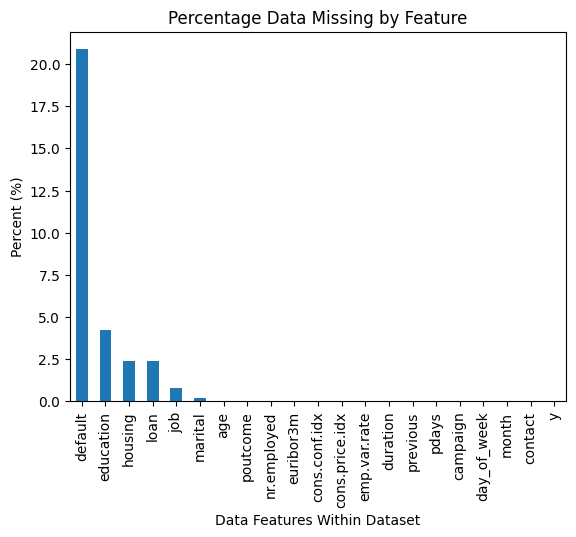

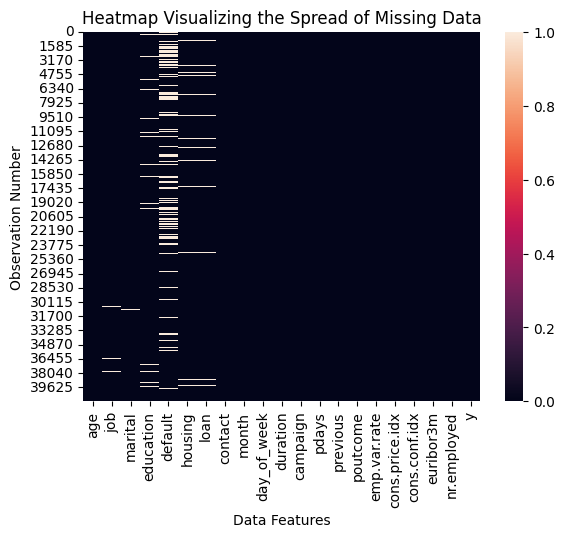

In [13]:
# The "unknown" values throughout the dataset are being viewed as NaN, so replace it to NaNs so heatmaps and such work out.
df = df.replace({"unknown":np.nan})

# Plot the missing values (uses custom function defined above)
review_missing_data( df )

In [14]:
# What percentage records would we lose if 
rows_orig = df.shape[0]
rows_dropna = df.dropna().shape[0]
print(f"% data loss if we drop all missing/unknown values: {(rows_orig - rows_dropna)/rows_orig * 100}")

% data loss if we drop all missing/unknown values: 25.978440322424007


**Let's start with dropping all records to see how models score**

In [15]:
df.duplicated().sum()

12

#### 3.3 Univariate Analysis


/───────────────────────────────────────────────────  FEATURE: JOB  ───────────────────────────────────────────────────/



,job,proportion
0,admin.,0.253035
1,blue-collar,0.224677
2,technician,0.163713
3,services,0.096363
4,management,0.070992
5,retired,0.041760
6,entrepreneur,0.035350
7,self-employed,0.034500
8,housemaid,0.025736
9,unemployed,0.024619


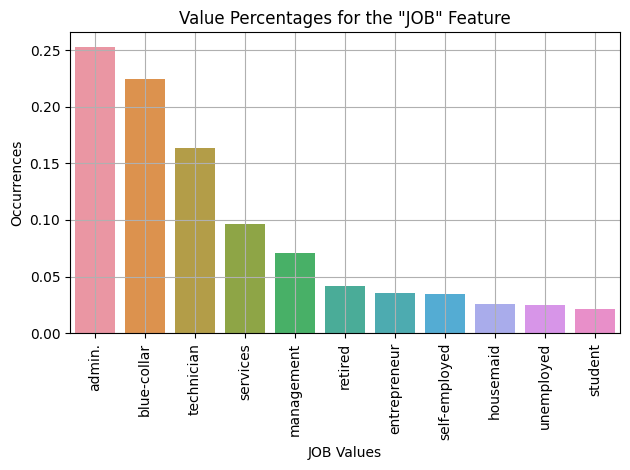


/─────────────────────────────────────────────────  FEATURE: MARITAL  ─────────────────────────────────────────────────/



,marital,proportion
0,married,0.605225
1,single,0.280859
2,divorced,0.111974
3,NaN,0.001942


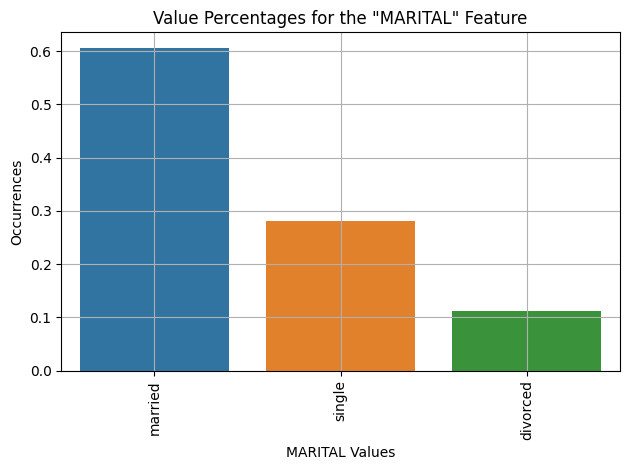


/────────────────────────────────────────────────  FEATURE: EDUCATION  ────────────────────────────────────────────────/



,education,proportion
0,university.degree,0.295426
1,high.school,0.231014
2,basic.9y,0.146766
3,professional.course,0.127294
4,basic.4y,0.101389
5,basic.6y,0.055647
6,NaN,0.042027
7,illiterate,0.000437


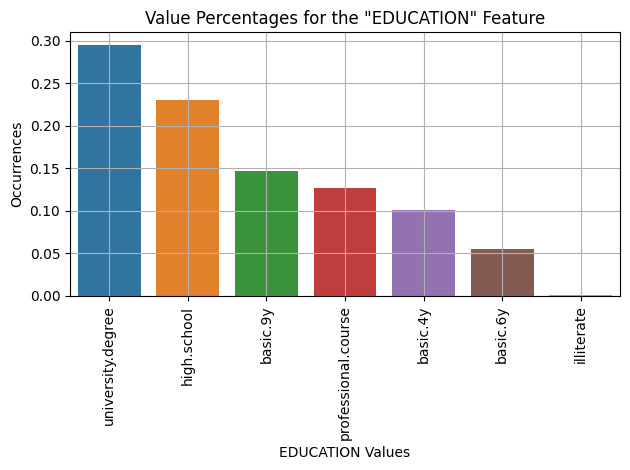


/─────────────────────────────────────────────────  FEATURE: DEFAULT  ─────────────────────────────────────────────────/



,default,proportion
0,no,0.791201
1,NaN,0.208726
2,yes,0.000073


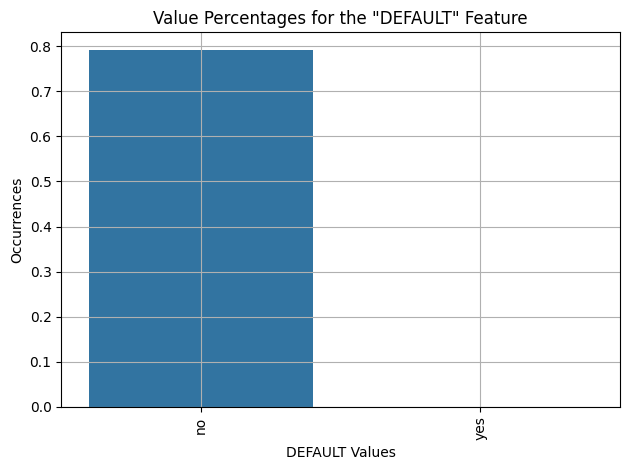


/─────────────────────────────────────────────────  FEATURE: HOUSING  ─────────────────────────────────────────────────/



,housing,proportion
0,yes,0.523842
1,no,0.452122
2,NaN,0.024036


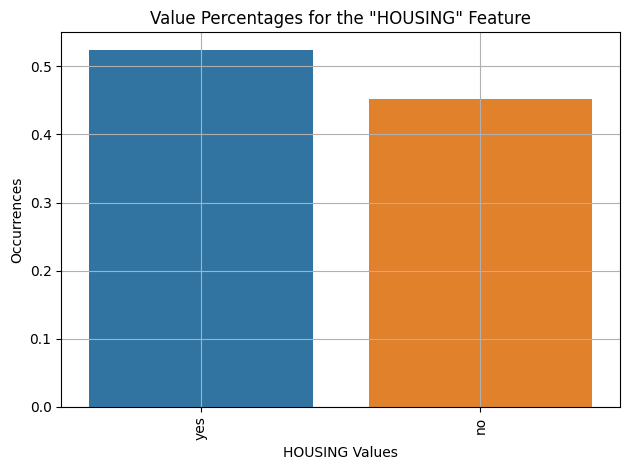


/──────────────────────────────────────────────────  FEATURE: LOAN  ──────────────────────────────────────────────────/



,loan,proportion
0,no,0.824269
1,yes,0.151695
2,NaN,0.024036


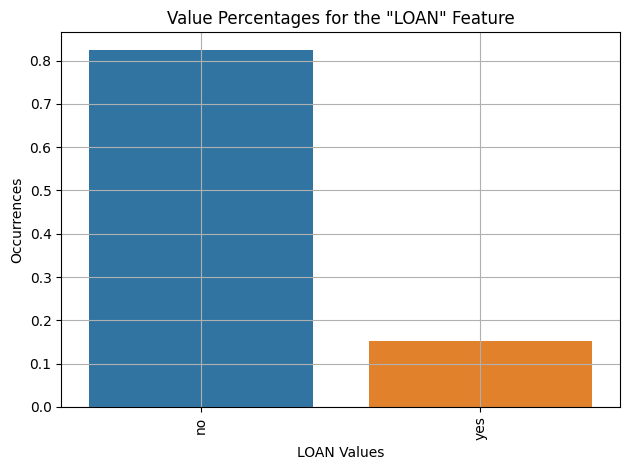


/─────────────────────────────────────────────────  FEATURE: CONTACT  ─────────────────────────────────────────────────/



,contact,proportion
0,cellular,0.634748
1,telephone,0.365252


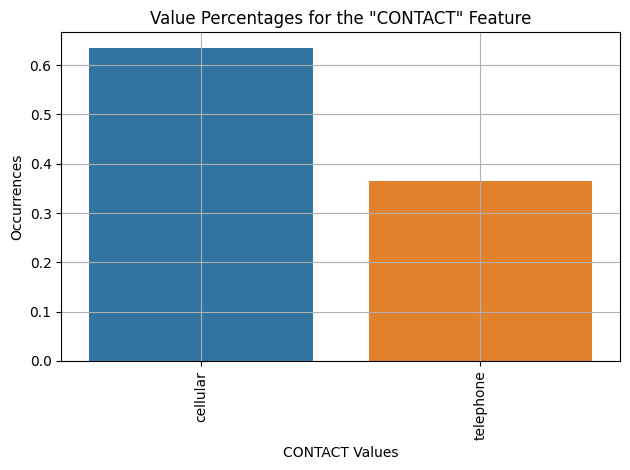


/──────────────────────────────────────────────────  FEATURE: MONTH  ──────────────────────────────────────────────────/



,month,proportion
0,may,0.334296
1,jul,0.174177
2,aug,0.149995
3,jun,0.129115
4,nov,0.099568
5,apr,0.063902
6,oct,0.017432
7,sep,0.013839
8,mar,0.013256
9,dec,0.004419


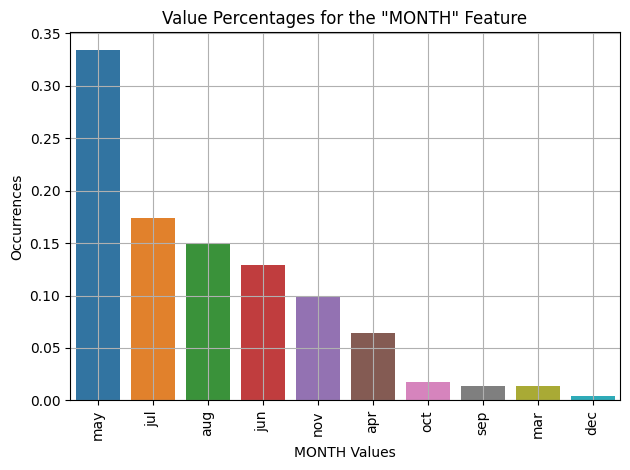


/───────────────────────────────────────────────  FEATURE: DAY_OF_WEEK  ───────────────────────────────────────────────/



,day_of_week,proportion
0,thu,0.209357
1,mon,0.206711
2,wed,0.197485
3,tue,0.196416
4,fri,0.190031


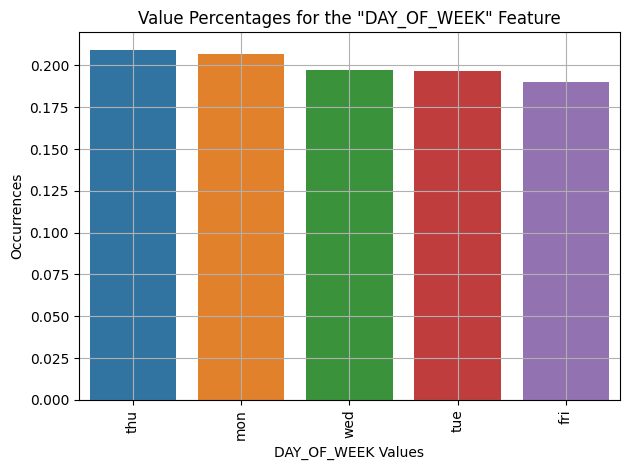


/────────────────────────────────────────────────  FEATURE: POUTCOME  ────────────────────────────────────────────────/



,poutcome,proportion
0,nonexistent,0.863431
1,failure,0.103234
2,success,0.033335


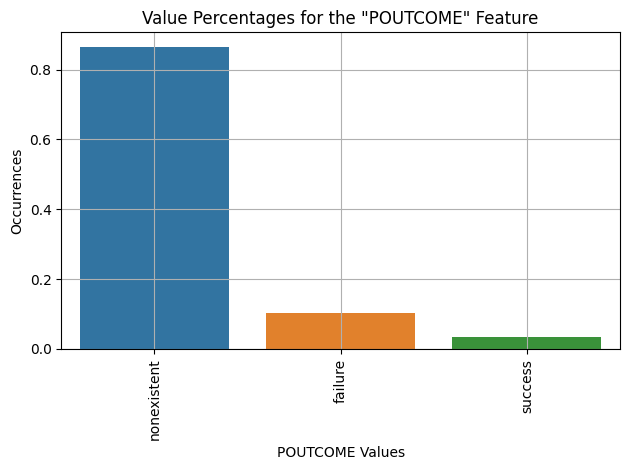


/────────────────────────────────────────────────────  FEATURE: Y  ────────────────────────────────────────────────────/



,y,proportion
0,no,0.887346
1,yes,0.112654


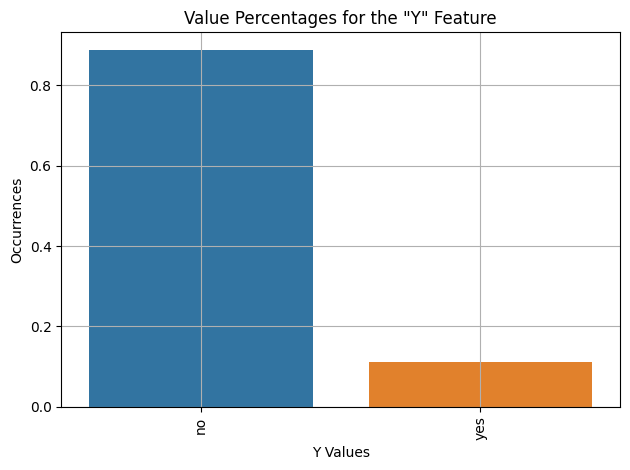

In [16]:
cat_columns = df.select_dtypes("object").columns.tolist()

for cmv in cat_columns:
    # Get feature's value counts as dataframe
    df_cmv = pd.DataFrame(df[cmv].value_counts( dropna=False, normalize=True ).sort_values( ascending=False )).reset_index()

    # Label for readability
    print( helper_print_heading( f'Feature: {cmv}' ))

    # Show tabular view of value counts for feature
    display( df_cmv )

    # Show plot of value counts for feature
    ax = sns.barplot( df_cmv, y='proportion', x=cmv )
    #ax.bar_label(ax.containers[0])
    plt.title(f'Value Percentages for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Occurrences')
    plt.xticks(rotation=90)
    plt.grid()
    plt.tight_layout()
    # Save figure for use in write-up, as needed
    plt.savefig(f'images/pa3-univariate-categorical-barplot-{cmv.lower()}.png')
    plt.show()

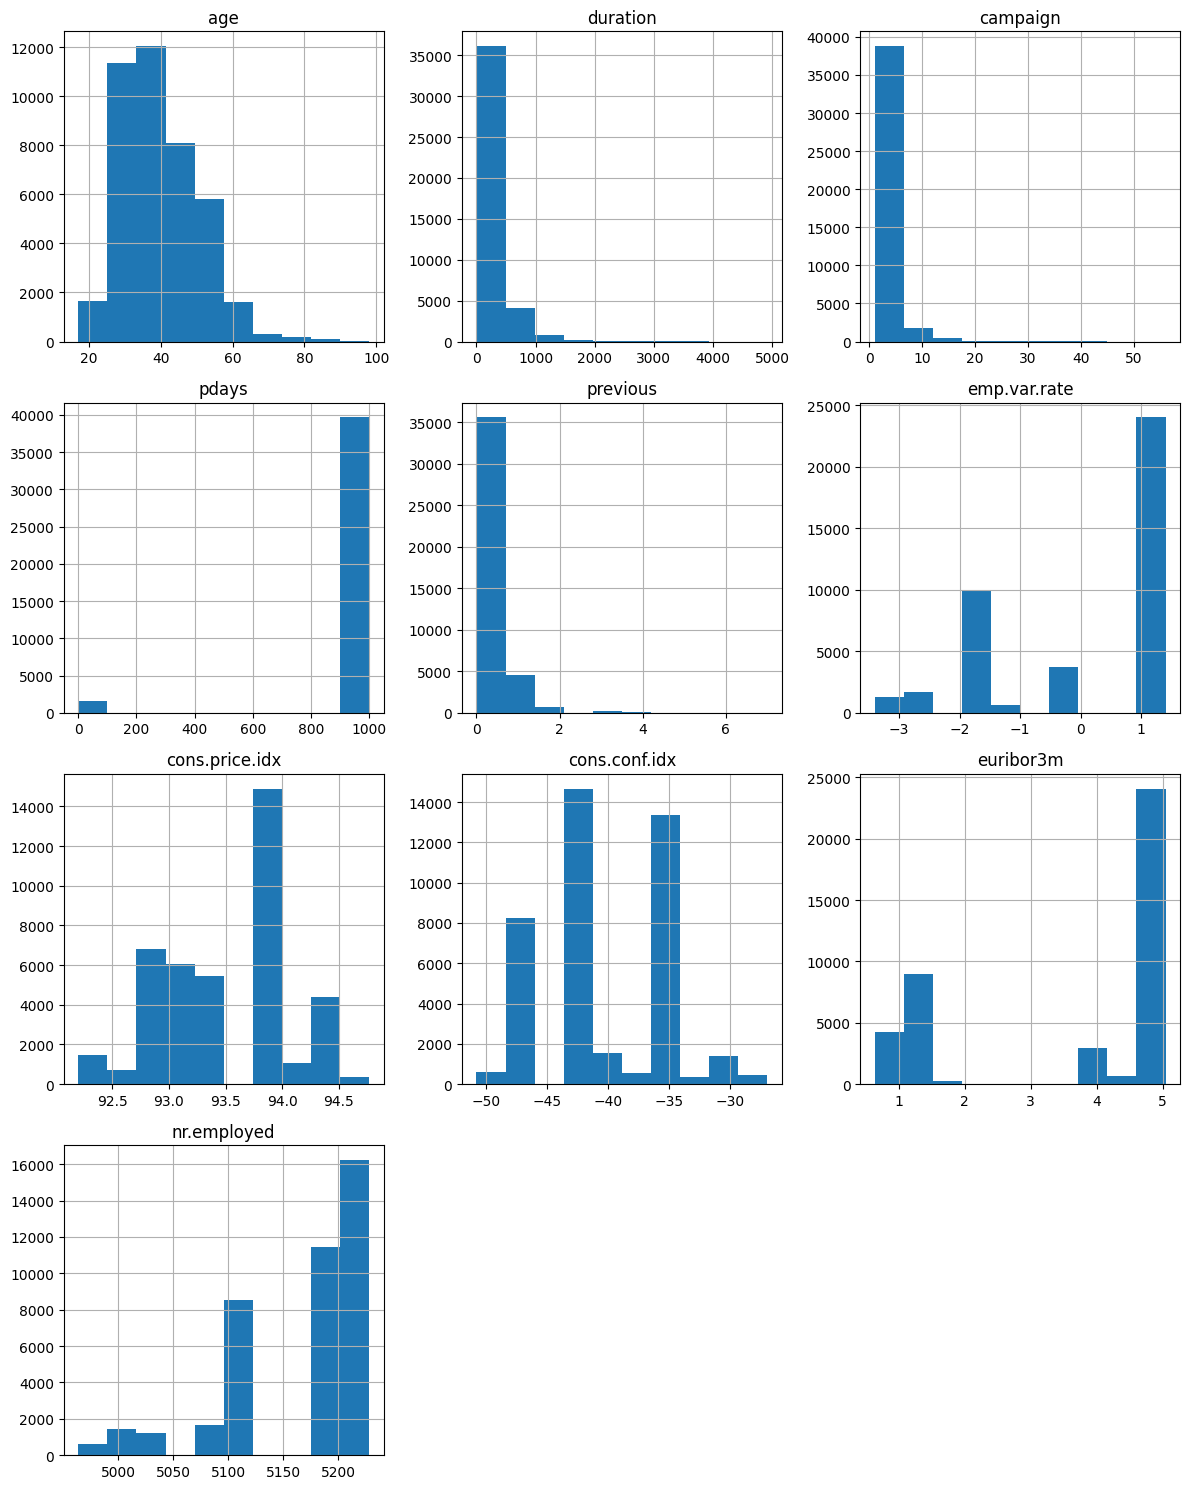

In [17]:
df.hist(figsize=(12,15))
plt.tight_layout()

#### 3.4 Bivariate Analysis

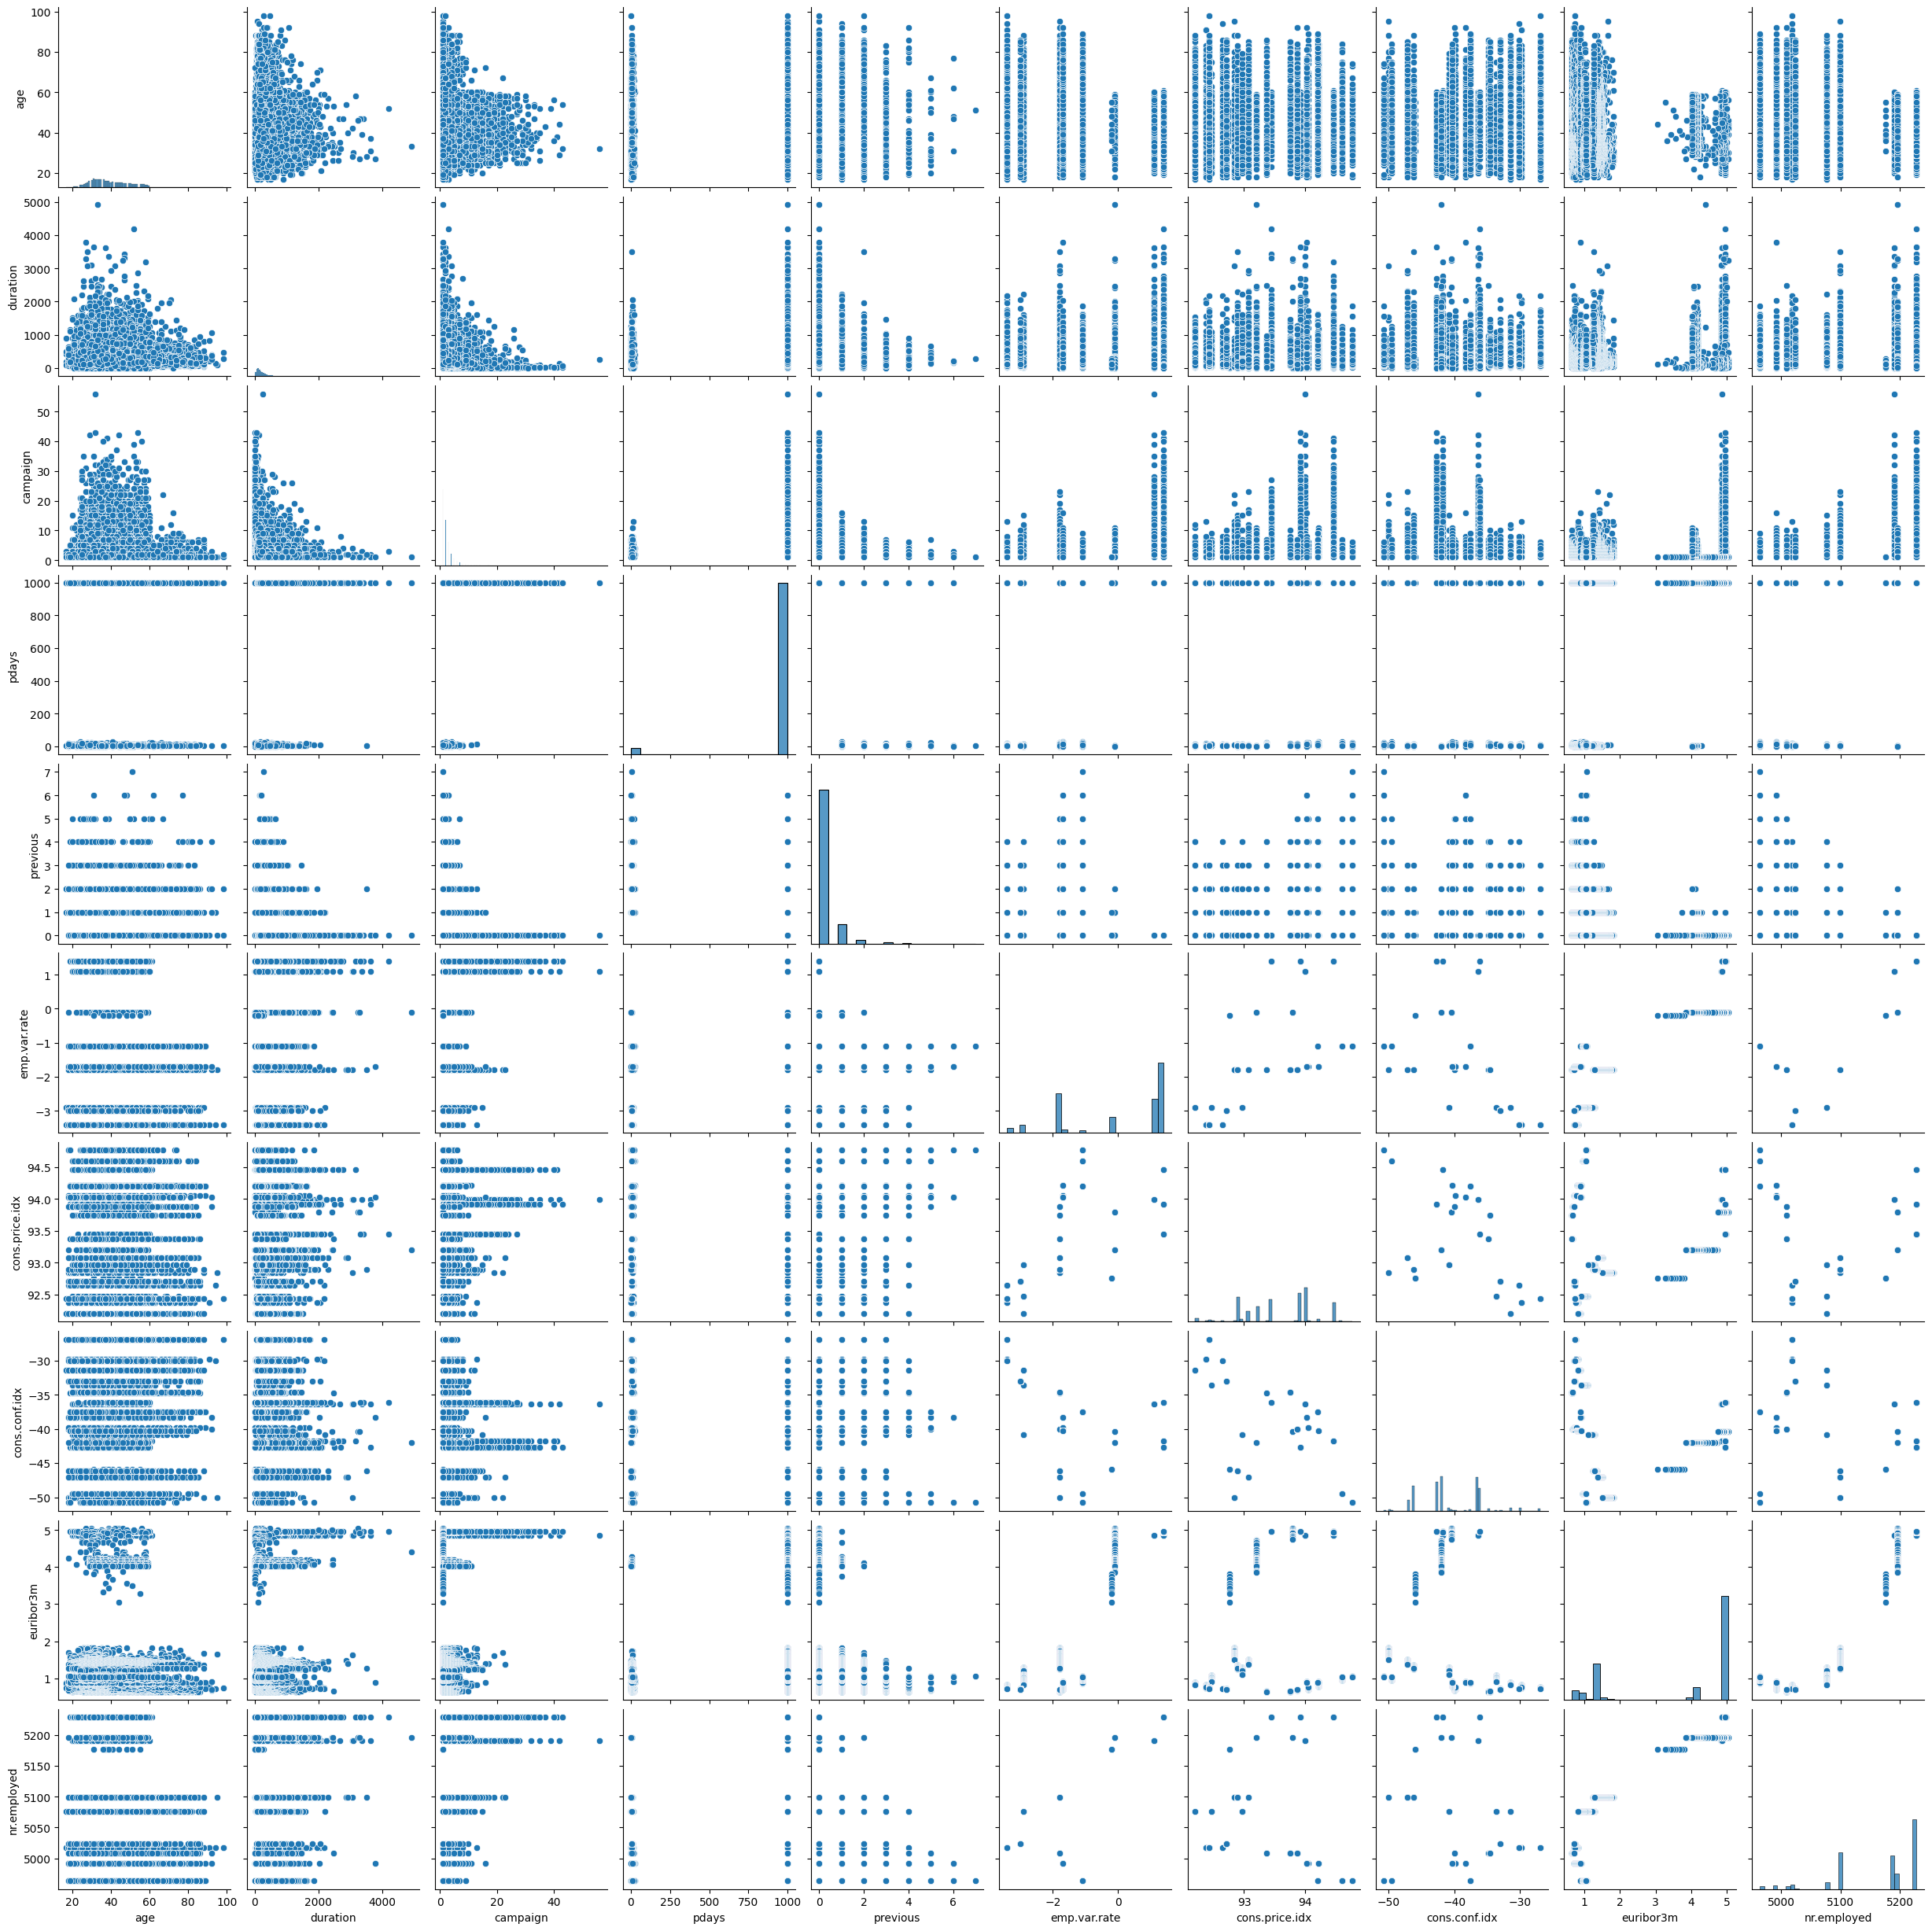

In [18]:
sns.pairplot( df )


/───────────────────────────────────────────────────  FEATURE: JOB  ───────────────────────────────────────────────────/



,job,y,count
0,admin.,no,9070
1,admin.,yes,1352
2,blue-collar,no,8616
3,blue-collar,yes,638
4,entrepreneur,no,1332
5,entrepreneur,yes,124
6,housemaid,no,954
7,housemaid,yes,106
8,management,no,2596
9,management,yes,328


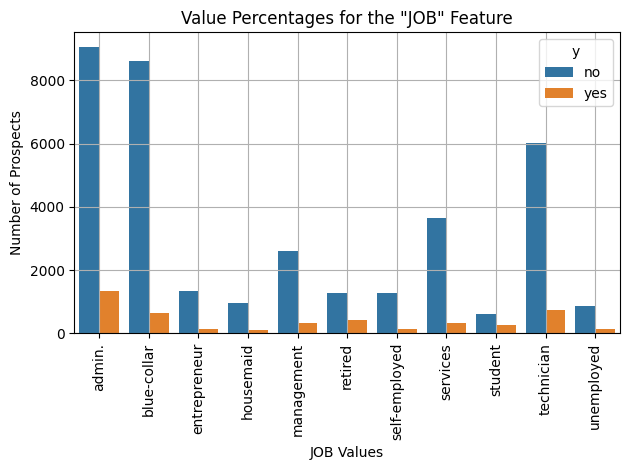


/─────────────────────────────────────────────────  FEATURE: MARITAL  ─────────────────────────────────────────────────/



,marital,y,count
0,divorced,no,4136
1,divorced,yes,476
2,married,no,22396
3,married,yes,2532
4,single,no,9948
5,single,yes,1620


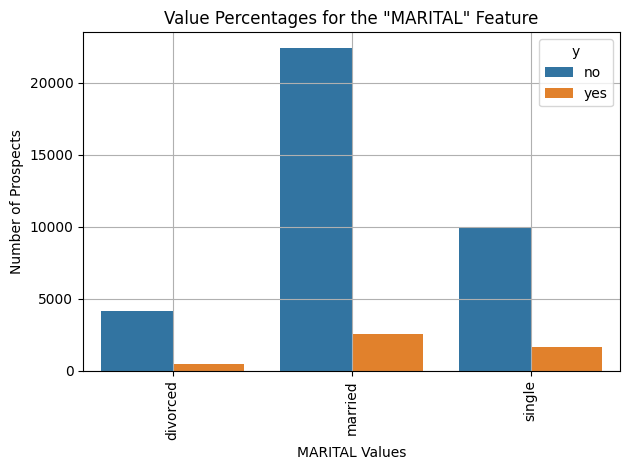


/────────────────────────────────────────────────  FEATURE: EDUCATION  ────────────────────────────────────────────────/



,education,y,count
0,basic.4y,no,3748
1,basic.4y,yes,428
2,basic.6y,no,2104
3,basic.6y,yes,188
4,basic.9y,no,5572
5,basic.9y,yes,473
6,high.school,no,8484
7,high.school,yes,1031
8,illiterate,no,14
9,illiterate,yes,4


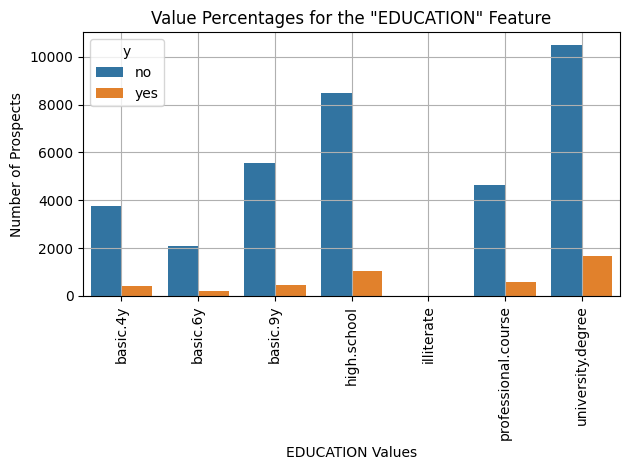


/─────────────────────────────────────────────────  FEATURE: DEFAULT  ─────────────────────────────────────────────────/



,default,y,count
0,no,no,28391
1,no,yes,4197
2,yes,no,3


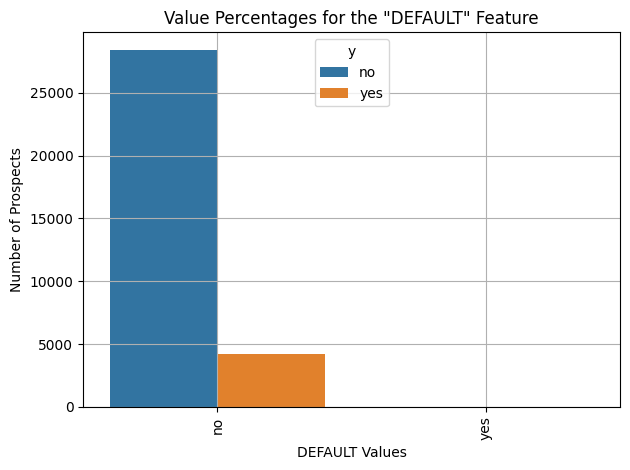


/─────────────────────────────────────────────────  FEATURE: HOUSING  ─────────────────────────────────────────────────/



,housing,y,count
0,no,no,16596
1,no,yes,2026
2,yes,no,19069
3,yes,yes,2507


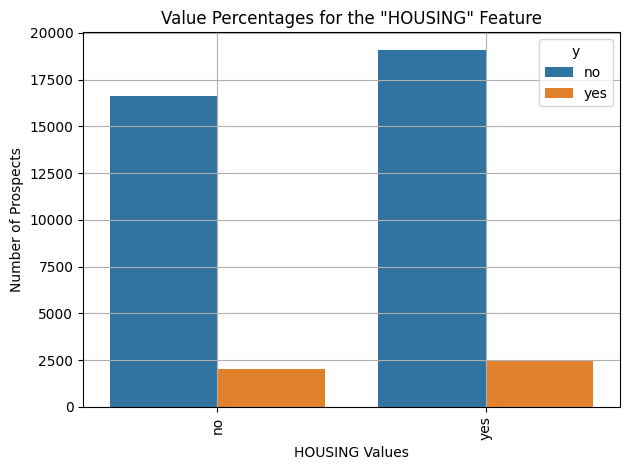


/──────────────────────────────────────────────────  FEATURE: LOAN  ──────────────────────────────────────────────────/



,loan,y,count
0,no,no,30100
1,no,yes,3850
2,yes,no,5565
3,yes,yes,683


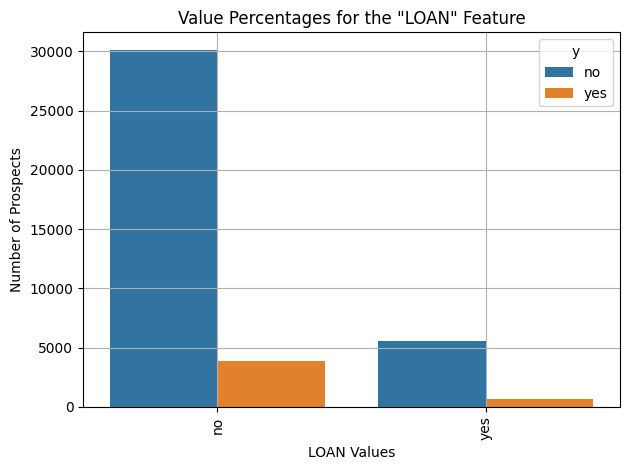


/─────────────────────────────────────────────────  FEATURE: CONTACT  ─────────────────────────────────────────────────/



,contact,y,count
0,cellular,no,22291
1,cellular,yes,3853
2,telephone,no,14257
3,telephone,yes,787


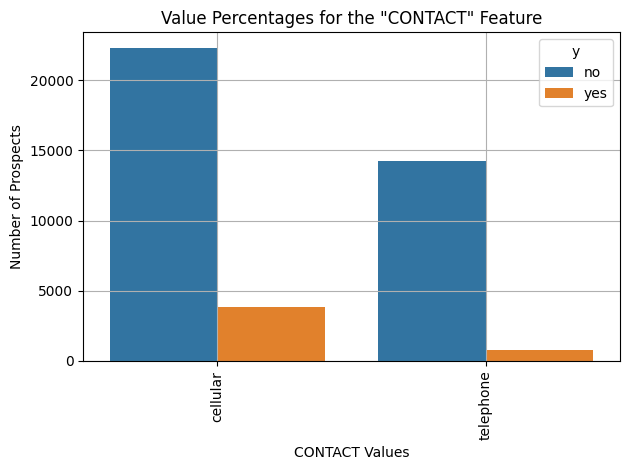


/──────────────────────────────────────────────────  FEATURE: MONTH  ──────────────────────────────────────────────────/



,month,y,count
0,apr,no,2093
1,apr,yes,539
2,aug,no,5523
3,aug,yes,655
4,dec,no,93
5,dec,yes,89
6,jul,no,6525
7,jul,yes,649
8,jun,no,4759
9,jun,yes,559


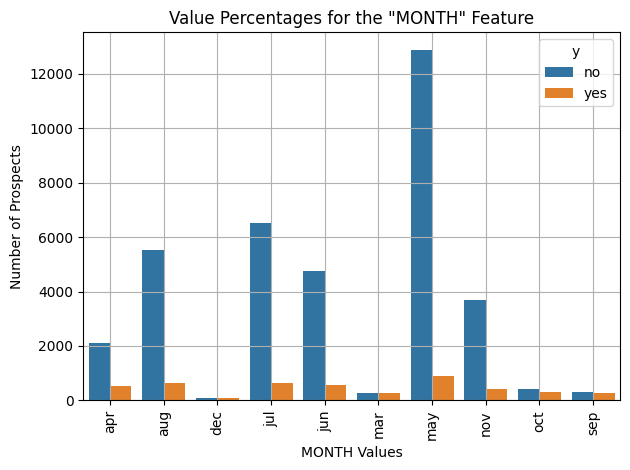


/───────────────────────────────────────────────  FEATURE: DAY_OF_WEEK  ───────────────────────────────────────────────/



,day_of_week,y,count
0,fri,no,6981
1,fri,yes,846
2,mon,no,7667
3,mon,yes,847
4,thu,no,7578
5,thu,yes,1045
6,tue,no,7137
7,tue,yes,953
8,wed,no,7185
9,wed,yes,949


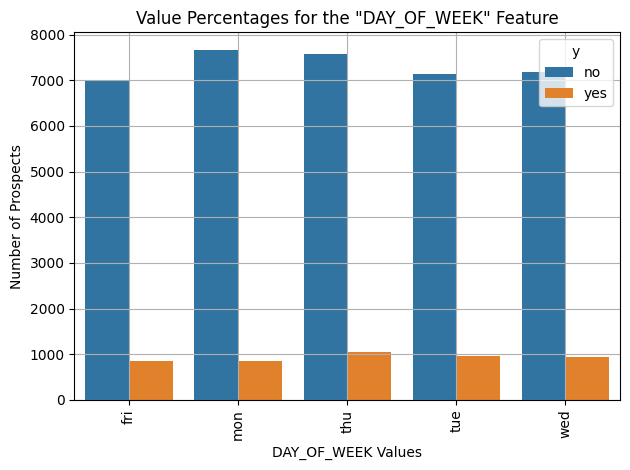


/────────────────────────────────────────────────  FEATURE: POUTCOME  ────────────────────────────────────────────────/



,poutcome,y,count
0,failure,no,3647
1,failure,yes,605
2,nonexistent,no,32422
3,nonexistent,yes,3141
4,success,no,479
5,success,yes,894


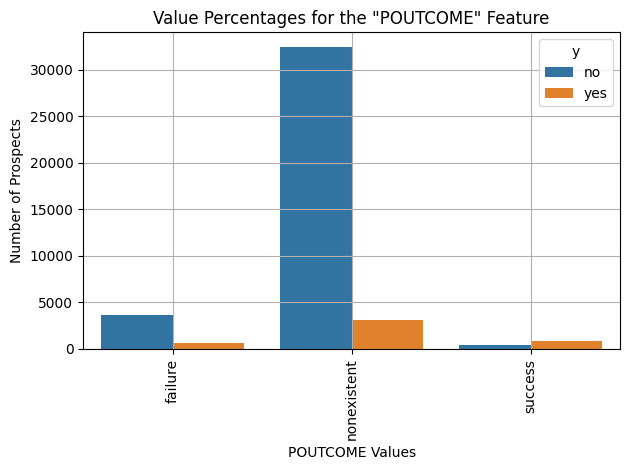

In [19]:
# Evaluate categorical features for how many subscribed to term deposits

for cmv in cat_columns:
    if cmv == 'y': continue;
        
    print( helper_print_heading( f'Feature: {cmv}' ))
    
    df_cmv = df.groupby([cmv,'y'])[['y']].count().rename(columns={'y':'count'}).reset_index()
    
    display( df_cmv )
    
    ax = sns.barplot( df_cmv, y='count', x=cmv, hue='y' )
    #ax.bar_label(ax.containers[0])
    plt.title(f'Value Percentages for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Number of Prospects')
    plt.xticks(rotation=90)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'images/pa3-bivariate-target-categorical-barplot-{cmv.lower()}.png')
    plt.show()

##### Review correlation matrix for any multicollinearity concerns

<Axes: >

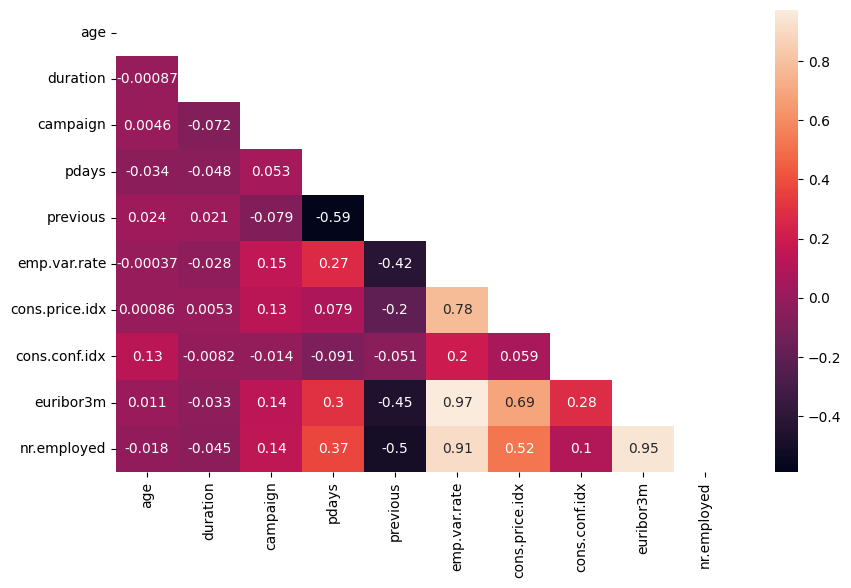

In [20]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True).round(2)))
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), mask=mask, annot=True)

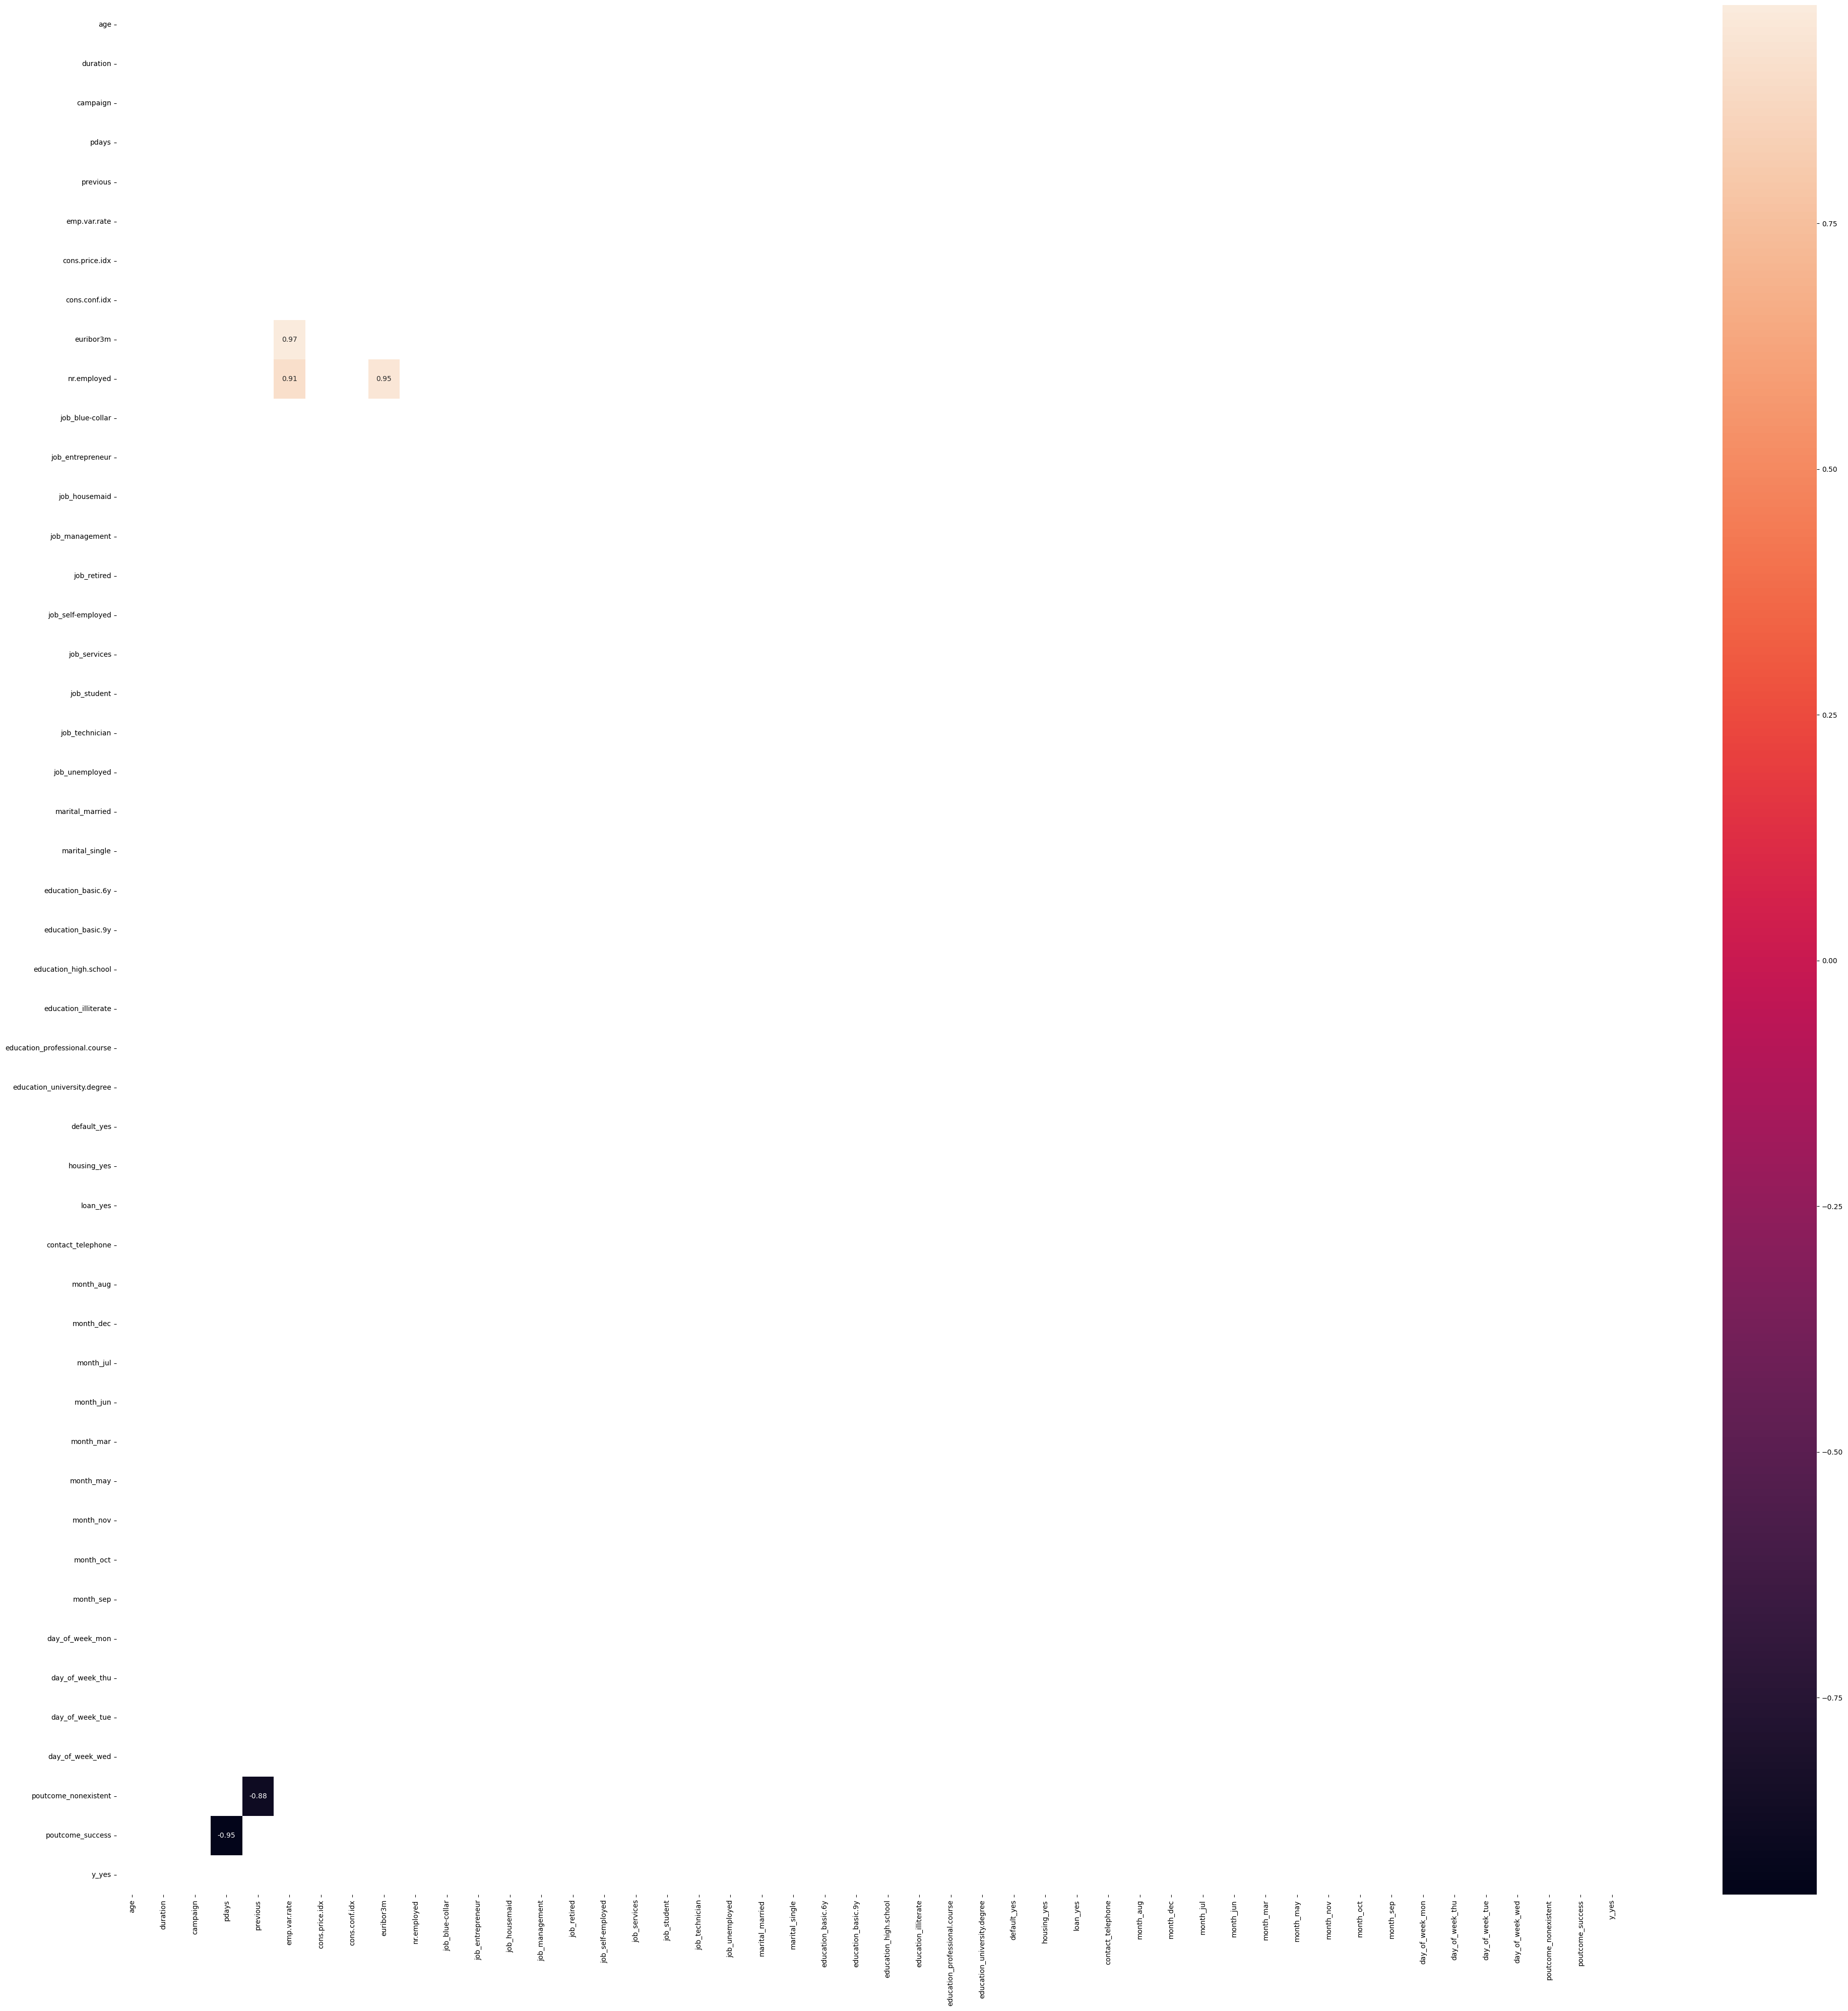

In [21]:
# What would the correlations look like if we binarized the categorical features?  Anything new?

X = pd.get_dummies(df, drop_first=True)
corr = X.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr.round(2)))
plt.figure(figsize=(40,40))
sns.heatmap(corr[abs(corr) > .85], mask=mask, annot=True)
plt.tight_layout()

##### What correlations occur for when the target feature is "yes" (desired outcome)?

<Axes: >

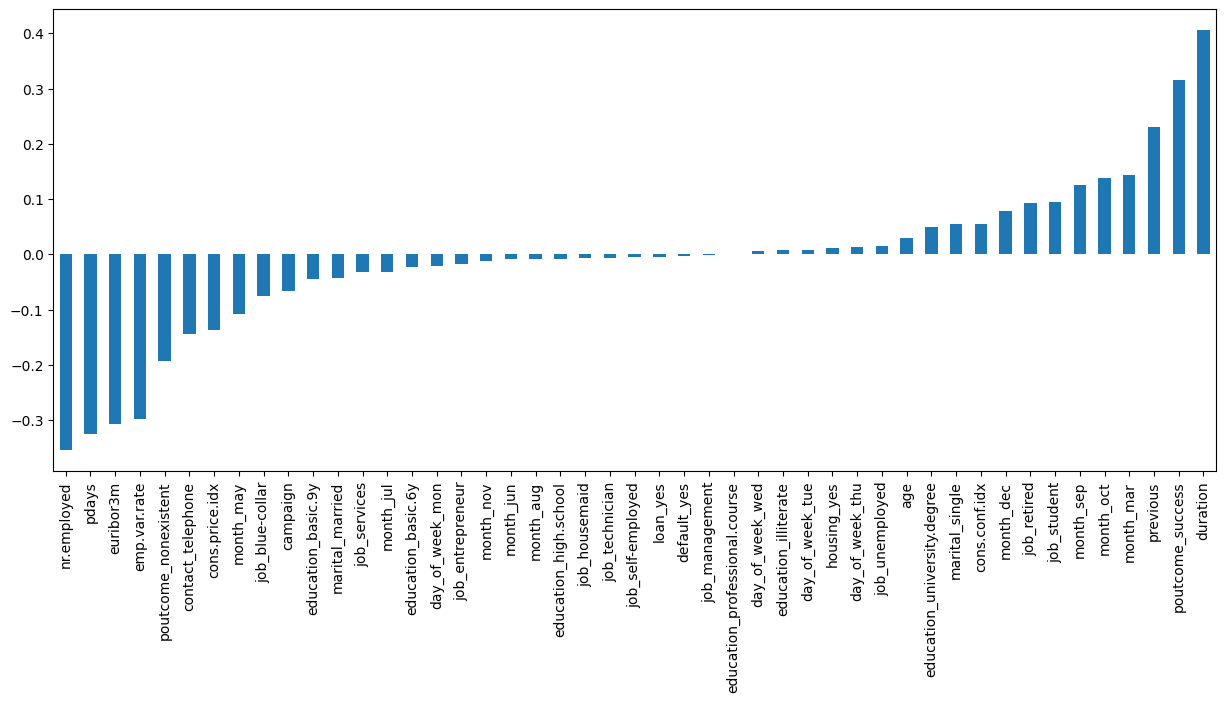

In [22]:
X.corr(numeric_only=True)["y_yes"].sort_values()[:-1].plot(kind="bar", figsize=(15,6))

---
#### Observations for Data Processing:
* Initially, let's drop all missing values to evaluate model scoring. Imputation can be revisited to improve model later.
* Duplicate values exist, they should be dropped
* Categorical features:
    * All categorical features seem to have reasonable number of unique values to be binarized; check correlations
    * Once binarized, the following features were highly correlated and should be removed:
        * `poutcome`: values highly correlated to `pdays` and `previous`, remove the feature (`poutcome`)
        * `emp.var.rate`, `nr.employed` and `euribor3m`: highly correlated to each other, drop 2 of them (`nr.employed`, `euribor3m`)
* Numerical features:
    * Most features do not have normal distributions
    * Values must be scaled
* Target feature:
    * Binarize target values
    * None of the binarized features seem to have high correlation to the target
---

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

---
#### Business Objective
* Increase efficiency of directed campaigns for long-term deposit subscriptions by improving contact targeting to those predicted as more likely to subscribe.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [23]:
# Steps followed:

# 1. drop duplicates and records with missing value(s)
df_dedupe = df.drop_duplicates().dropna()

# 2. create a new dataframe with only the first 7 predictive features and target
df7 = pd.concat([ df_dedupe.iloc[:,:7], df_dedupe.iloc[:,-1] ], axis = 1)

# 3. binarize categorical features
df7_bin = pd.get_dummies( df7, drop_first=True )

# 4. convert boolean values to numeric equivilents to support MSE
df7_bin = df7_bin.replace({False: 0, True: 1})

df7_bin.describe().T

,count,mean,std,min,25%,50%,75%,max
age,30478.0,39.029694,10.332746,17.0,31.0,37.0,45.0,95.0
job_blue-collar,30478.0,0.186167,0.389248,0.0,0.0,0.0,0.0,1.0
job_entrepreneur,30478.0,0.035731,0.185621,0.0,0.0,0.0,0.0,1.0
job_housemaid,30478.0,0.022639,0.148753,0.0,0.0,0.0,0.0,1.0
job_management,30478.0,0.075825,0.264723,0.0,0.0,0.0,0.0,1.0
job_retired,30478.0,0.039865,0.195645,0.0,0.0,0.0,0.0,1.0
job_self-employed,30478.0,0.035829,0.185867,0.0,0.0,0.0,0.0,1.0
job_services,30478.0,0.093707,0.291425,0.0,0.0,0.0,0.0,1.0
job_student,30478.0,0.020014,0.140052,0.0,0.0,0.0,0.0,1.0
job_technician,30478.0,0.179441,0.383727,0.0,0.0,0.0,0.0,1.0


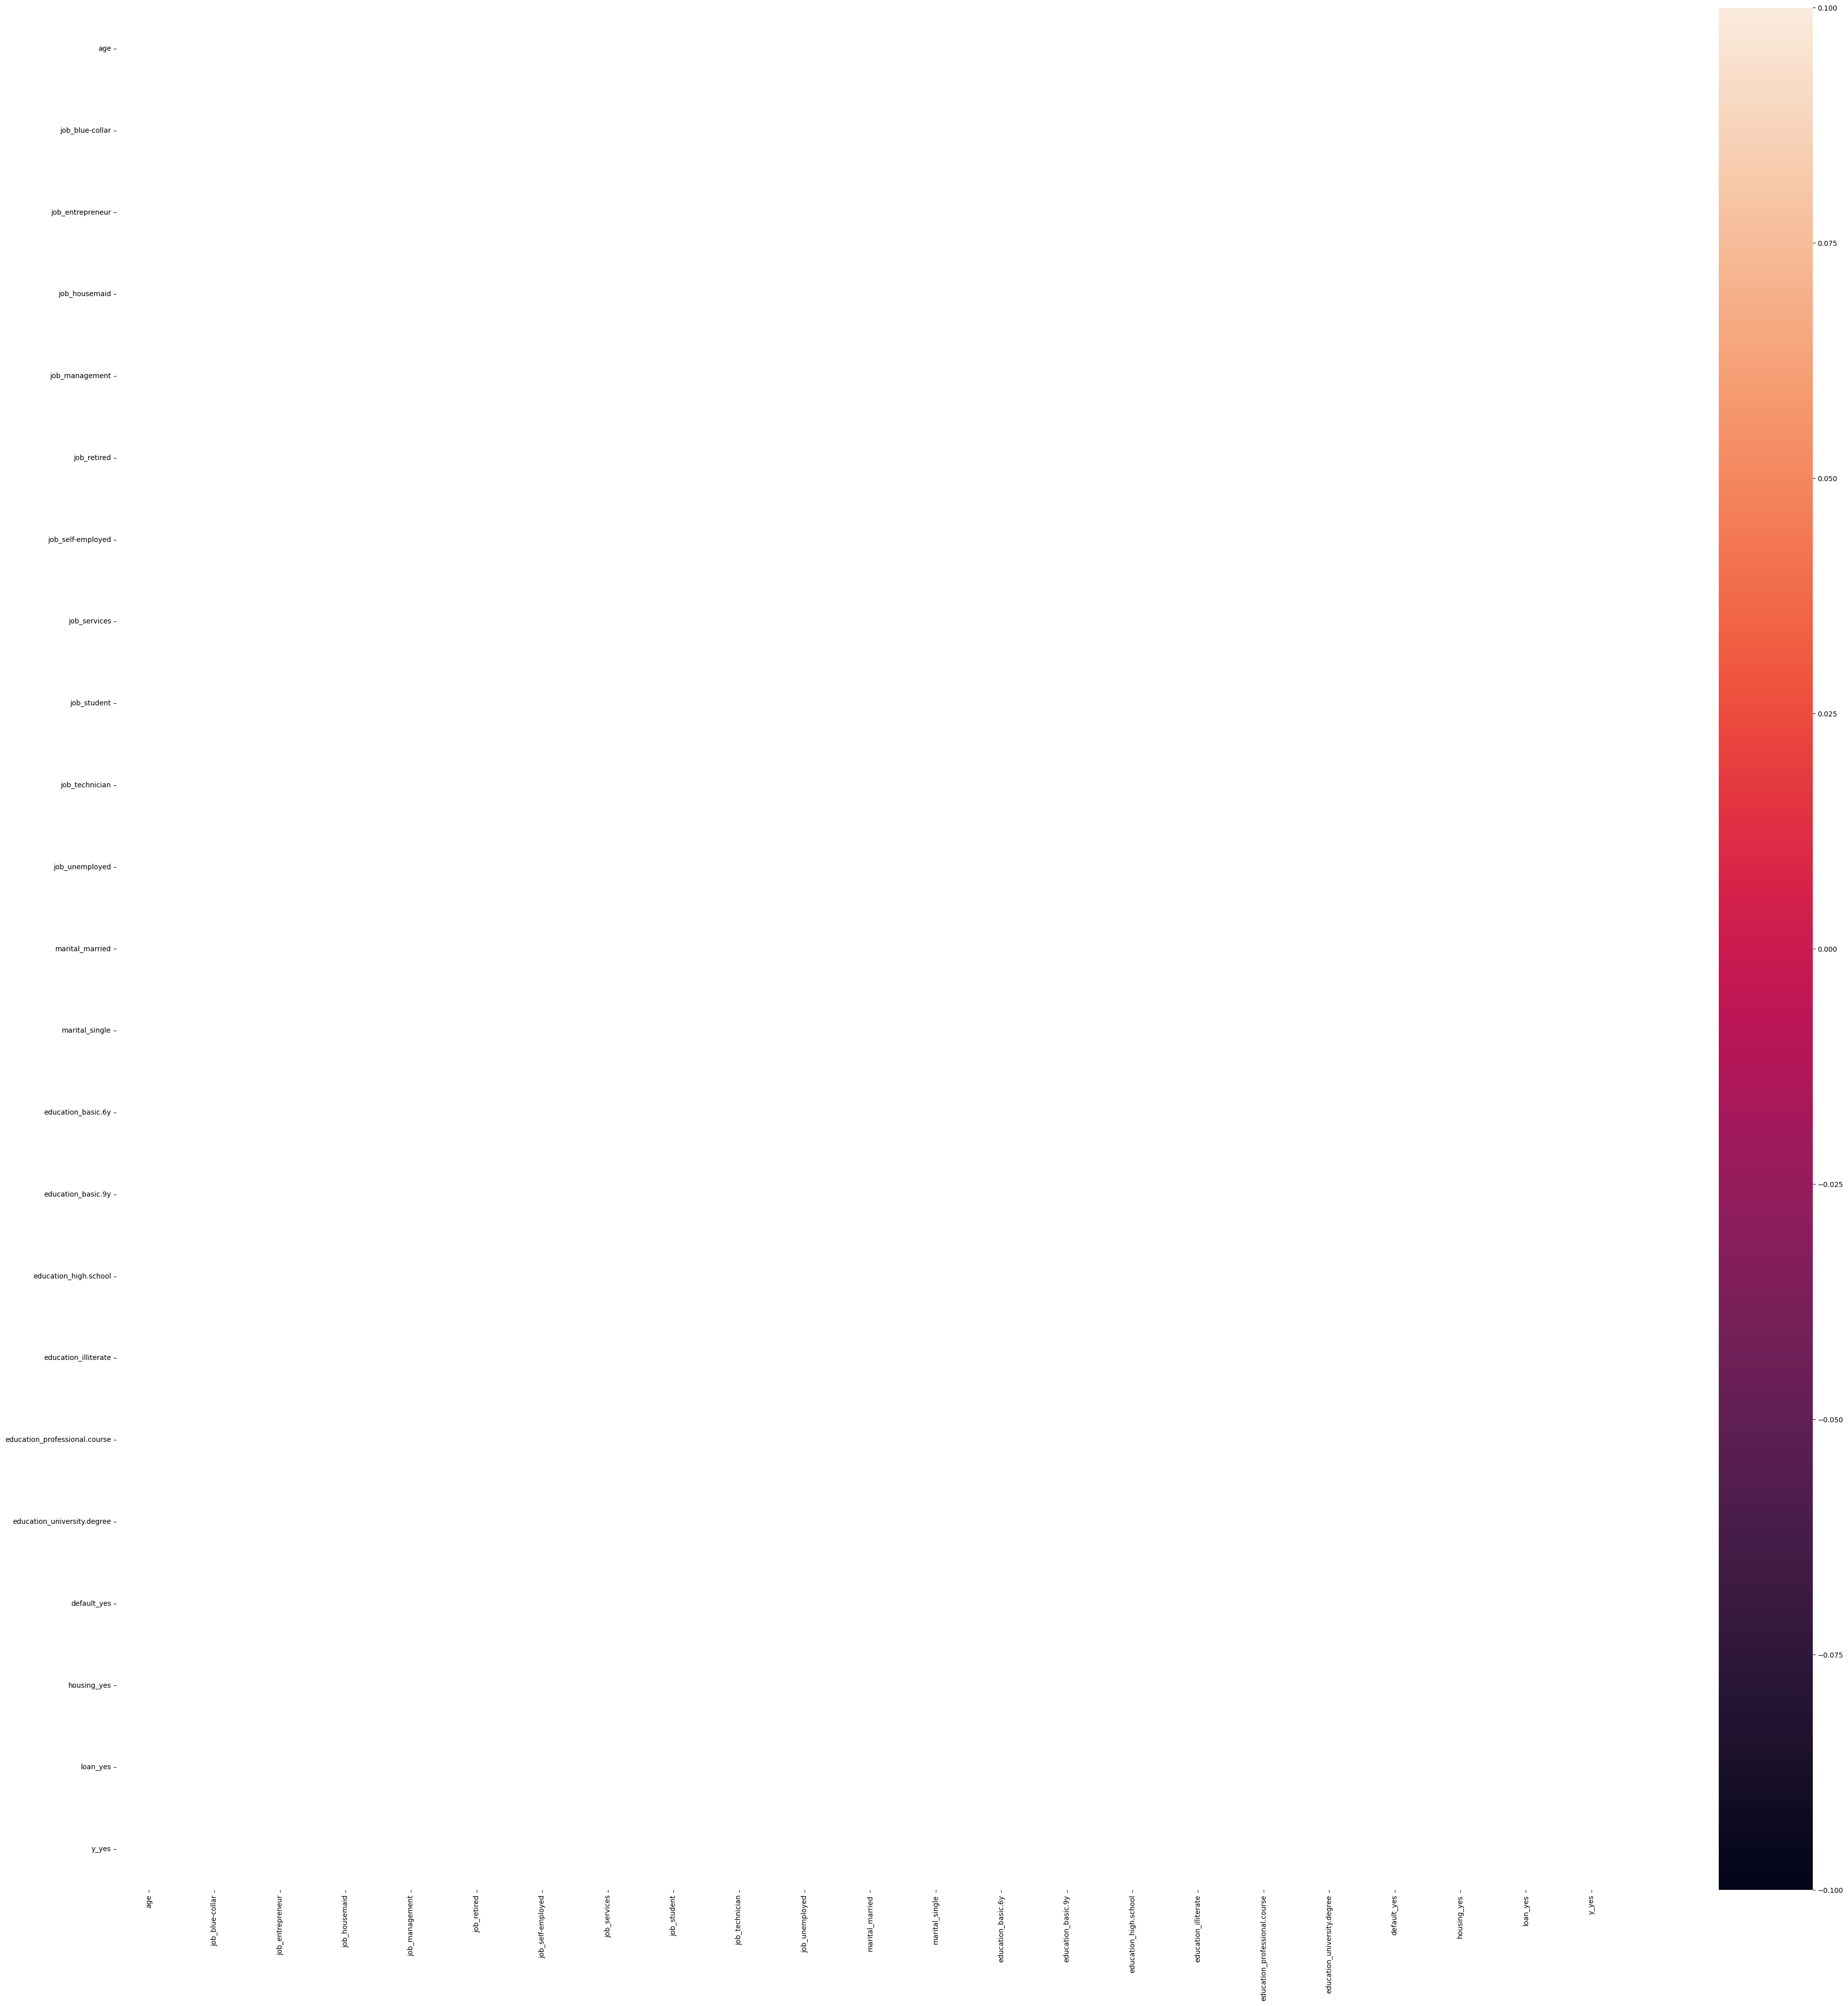

In [24]:
corr = df7_bin.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr.round(2)))
plt.figure(figsize=(40,40))
sns.heatmap(corr[abs(corr) > .85], mask=mask, annot=True)
plt.tight_layout()

In [25]:
df7_clean = df7_bin.copy()

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [26]:

X = df7_clean.drop(["y_yes"], axis=1)
y = df7_clean["y_yes"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=22 )

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, display(X_train.columns)

Index(['age', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_yes', 'housing_yes', 'loan_yes'],
      dtype='object')

((21334, 22), (9144, 22), (21334,), (9144,), None)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [29]:
# Use sklearn's DummyClassifier() model to baseline classification performance

# Train and fit dummy model
clf_bl = DummyClassifier()

# start the clock to understand fit time
start_time = time.time()
clf_bl.fit( X_train, y_train )
bl_fit = time.time() - start_time

# Train and Test scores
bl_train_score = clf_bl.score( X_train, y_train )
bl_test_score = clf_bl.score( X_test, y_test )

# Train and Test MSEs
bl_train_mse = mean_squared_error( clf_bl.predict( X_train ), y_train )
bl_test_mse = mean_squared_error( clf_bl.predict( X_test ), y_test )

print(
    "\nBaseline values:\n------------------"
    f"\nFit Time:\t{bl_fit:.4f} seconds"
    f"\nTraining Set:\tScore: {bl_train_score:.4f} \t MSE: {bl_train_mse:.4f}"
    f"\nTest Set:\tScore: {bl_test_score:.4f} \t MSE: {bl_test_mse:.4f}"
)


Baseline values:
------------------
Fit Time:	0.0016 seconds
Training Set:	Score: 0.8741 	 MSE: 0.1259
Test Set:	Score: 0.8717 	 MSE: 0.1283


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [30]:
clf_lgr = LogisticRegression()

# start the clock to understand fit time
start_time = time.time()
clf_lgr.fit( X_train, y_train )
lgr_fit = time.time() - start_time

### Problem 9: Score the Model

What is the accuracy of your model?

In [31]:
# Train and Test scores
lgr_train_score = clf_lgr.score( X_train, y_train )
lgr_test_score = clf_lgr.score( X_test, y_test )

# Train and Test MSEs
lgr_train_mse = mean_squared_error( clf_lgr.predict( X_train ), y_train )
lgr_test_mse = mean_squared_error( clf_lgr.predict( X_test ), y_test )

print(
    "\nBaseline values:\n------------------"
    f"\nFit Time:\t{lgr_fit:.4f} seconds"
    f"\nTraining Set:\tScore: {lgr_train_score:.4f} \t MSE: {lgr_train_mse:.4f}"
    f"\nTest Set:\tScore: {lgr_test_score:.4f} \t MSE: {lgr_test_mse:.4f}"
)


Baseline values:
------------------
Fit Time:	0.1434 seconds
Training Set:	Score: 0.8741 	 MSE: 0.1259
Test Set:	Score: 0.8717 	 MSE: 0.1283


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [32]:
results_df = pd.DataFrame( columns=[ 'Model', 'Train Time', 'Train Accuracy', 'Test Accuracy' ] ).set_index( 'Model' )
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,


#### 10.1 Dummy Classifier as baseline

In [33]:
# Add the baseline scores:
results_df.loc['Baseline (Dummy)'] = [ bl_fit, bl_train_score, bl_test_score ]

# Add the Logistic Regression scores:
results_df.loc['Logistic Regression'] = [ lgr_fit, lgr_train_score, lgr_test_score ]

results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
Baseline (Dummy),0.001625,0.874145,0.871719
Logistic Regression,0.143434,0.874145,0.871719


#### 10.2 KNN model with default settings

In [34]:
clf_knn = KNeighborsClassifier()

# start the clock to understand fit time
start_time = time.time()
clf_knn.fit( X_train, y_train )
knn_fit = time.time() - start_time

# Train and Test scores
knn_train_score = clf_knn.score( X_train.values, y_train )
knn_test_score = clf_knn.score( X_test.values, y_test )

# Train and Test MSEs
knn_train_mse = mean_squared_error( clf_knn.predict( X_train.values ), y_train )
knn_test_mse = mean_squared_error( clf_knn.predict( X_test.values ), y_test )

# Push results into dataframe
results_df.loc['K-Nearest Neighbors'] = [ knn_fit, knn_train_score, knn_test_score ]

print(
    "\nBaseline values:\n------------------"
    f"\nFit Time:\t{knn_fit:.4f} seconds"
    f"\nTraining Set:\tScore: {knn_train_score:.4f} \t MSE: {knn_train_mse:.4f}"
    f"\nTest Set:\tScore: {knn_test_score:.4f} \t MSE: {knn_test_mse:.4f}"
)
results_df


Baseline values:
------------------
Fit Time:	0.0084 seconds
Training Set:	Score: 0.8764 	 MSE: 0.1236
Test Set:	Score: 0.8544 	 MSE: 0.1456


,Train Time,Train Accuracy,Test Accuracy
Model,,,
Baseline (Dummy),0.001625,0.874145,0.871719
Logistic Regression,0.143434,0.874145,0.871719
K-Nearest Neighbors,0.008359,0.876394,0.854440


#### 10.3 Decision Tree model with default settings

In [35]:
clf_dt = DecisionTreeClassifier()

# start the clock to understand fit time
start_time = time.time()
clf_dt.fit( X_train, y_train )
dt_fit = time.time() - start_time

# Train and Test scores
dt_train_score = clf_dt.score( X_train, y_train )
dt_test_score = clf_dt.score( X_test, y_test )

# Train and Test MSEs
dt_train_mse = mean_squared_error( clf_dt.predict( X_train ), y_train )
dt_test_mse = mean_squared_error( clf_dt.predict( X_test ), y_test )

# Push results into dataframe
results_df.loc['Decision Tree'] = [ dt_fit, dt_train_score, dt_test_score ]

print(
    "\nBaseline values:\n------------------"
    f"\nFit Time:\t{dt_fit:.4f} seconds"
    f"\nTraining Set:\tScore: {dt_train_score:.4f} \t MSE: {dt_train_mse:.4f}"
    f"\nTest Set:\tScore: {dt_test_score:.4f} \t MSE: {dt_test_mse:.4f}"
)
results_df


Baseline values:
------------------
Fit Time:	0.0303 seconds
Training Set:	Score: 0.9038 	 MSE: 0.0962
Test Set:	Score: 0.8461 	 MSE: 0.1539


,Train Time,Train Accuracy,Test Accuracy
Model,,,
Baseline (Dummy),0.001625,0.874145,0.871719
Logistic Regression,0.143434,0.874145,0.871719
K-Nearest Neighbors,0.008359,0.876394,0.854440
Decision Tree,0.030254,0.903816,0.846129


#### 10.4 SVM model with default settings

In [36]:
clf_svm = SVC()

# start the clock to understand fit time
start_time = time.time()
clf_svm.fit( X_train, y_train )
svm_fit = time.time() - start_time

# Train and Test scores
svm_train_score = clf_svm.score( X_train, y_train )
svm_test_score = clf_svm.score( X_test, y_test )

# Train and Test MSEs
svm_train_mse = mean_squared_error( clf_svm.predict( X_train ), y_train )
svm_test_mse = mean_squared_error( clf_svm.predict( X_test ), y_test )

# Push results into dataframe
results_df.loc['SVM'] = [ svm_fit, svm_train_score, svm_test_score ]

print(
    "\nBaseline values:\n------------------"
    f"\nFit Time:\t{svm_fit:.4f} seconds"
    f"\nTraining Set:\tScore: {svm_train_score:.4f} \t MSE: {svm_train_mse:.4f}"
    f"\nTest Set:\tScore: {svm_test_score:.4f} \t MSE: {svm_test_mse:.4f}"
)


Baseline values:
------------------
Fit Time:	2.1888 seconds
Training Set:	Score: 0.8741 	 MSE: 0.1259
Test Set:	Score: 0.8717 	 MSE: 0.1283


#### 10.5 Compare Classifier Modeling Results

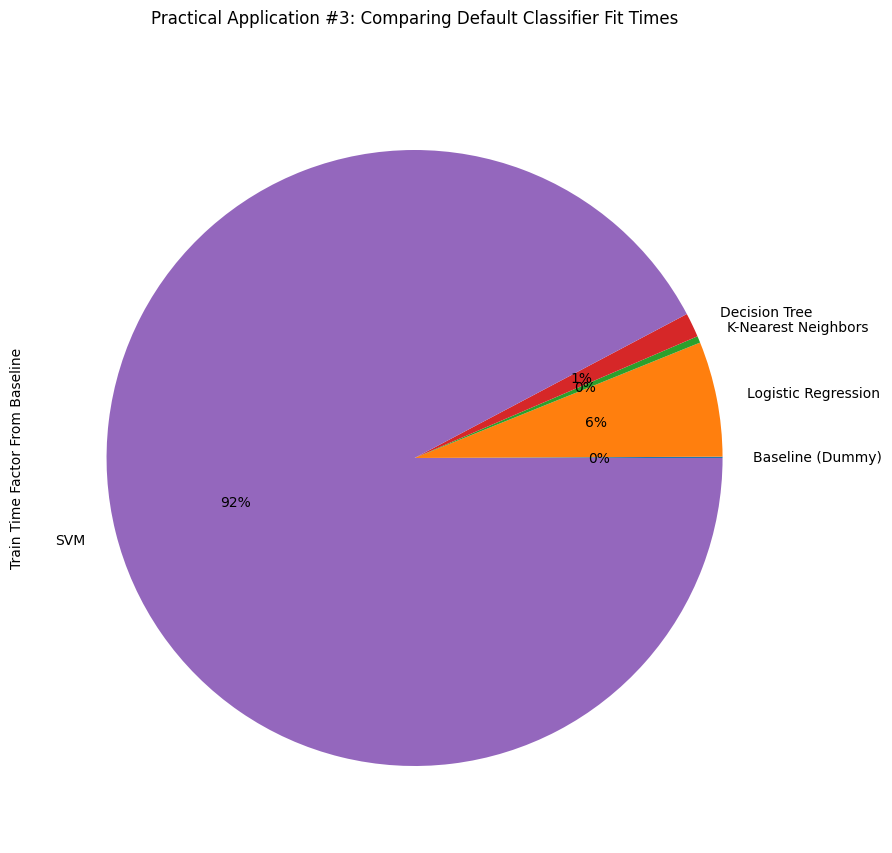

,Train Time,Train Accuracy,Test Accuracy,Train Time Factor From Baseline
Model,,,,
Baseline (Dummy),0.001625,0.874145,0.871719,1.000000
K-Nearest Neighbors,0.008359,0.876394,0.854440,5.143779
Decision Tree,0.030254,0.903816,0.846129,18.617077
Logistic Regression,0.143434,0.874145,0.871719,88.263644
SVM,2.188755,0.874145,0.871719,1346.875440


In [37]:
# Normalize result data
results_df["Train Time Factor From Baseline"] = results_df["Train Time"] / results_df["Train Time"].min()

# Save the results to CSV for offline review
results_df.reset_index().to_csv("results/comparing-classifiers-default-performance.csv", index=False)
                                                                    
results_df["Train Time Factor From Baseline"].plot(kind="pie", autopct='%1.0f%%', figsize=(10,10), title="Practical Application #3: Comparing Default Classifier Fit Times\n\n");

# Save figure for use in write-up, as needed
plt.savefig(f'images/pa3-classifier-results-default-settings.png')

plt.show()
display(results_df.sort_values("Train Time Factor From Baseline"))

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### 11.1 Create a dataframe to coallate model results

In [38]:
improved_results_df = pd.DataFrame( columns=['classifier', 'scoring', 'train score', 'test score', 'cv time', 'average fit time', 'best params'] )
improved_results_df

,classifier,scoring,train score,test score,cv time,average fit time,best params


#### 11.2 Create train/test datasets

In [39]:
X = df_dedupe.drop( ["y", "poutcome", "nr.employed", "euribor3m"], axis=1 )
y = df_dedupe["y"].replace({ "no": 0, "yes": 1 })

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state = 22 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

cats = X.select_dtypes(include=["object"]).columns
nums = X.select_dtypes(exclude=["object"]).columns
cats, nums

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week'],
       dtype='object'),
 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx'],
       dtype='object'))

#### 11.3 Setup general transformer used by each classifier

In [40]:
col_transformer = make_column_transformer(
                        (OneHotEncoder(drop = 'if_binary'), cats), 
                        remainder=StandardScaler()
                )
col_transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week'],
      dtype='object'))])

#### 11.4 Setup pipeline and hyperparameters by classifier

In [41]:
modelConfigurations = {
    # Logistic Regression configurations
    'lgr': {
        'label': 'Logistic Regression',
        'pipe': Pipeline ([
                    ('trans', col_transformer),
                    ('clf', LogisticRegression(max_iter = 1000))
                ]),
        'params': {
                    'clf__C': [0.01, 0.1, 1, 10, 100],
                    'clf__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
                }
    },
    # Decision Tree configurations
    'dtree': {
        'label': 'Decision Tree',
        'pipe': Pipeline ([
                    ('trans', col_transformer),
                    ('clf', DecisionTreeClassifier())
                ]),
        'params': {
                 'clf__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
                 'clf__max_depth': [2, 5, 10],
                 'clf__min_samples_split': [0.1, 0.2, 0.05]
                }
    },
    # K-Nearest Neighbors
    'knn': {
        'label': 'K-Nearest Neighbors',
        'pipe': Pipeline ([
                    ('trans', col_transformer),
                    ('clf', KNeighborsClassifier())
                ]),
        'params': { 
                    'clf__n_neighbors': list(range(3, 23, 2)),
                    'clf__weights': ['uniform', 'distance'],
                    'clf__p': [1, 2, 3, 4]           
                }
    },
    # Support Vector Machine configurations
    'svm': {
        'label': 'Support Vector Machines',
        'pipe': Pipeline ([
                    ('trans', col_transformer),
                    ('clf', SVC())
                ]),
        'params': { 
                    'clf__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
                    'clf__gamma': [0.1, 1.0, 10.0]
                 }
    }
}

#### 11.5 Cross-validation and Optimization

In [42]:
# Using a set of custom functions, iterate through each classifier to determine it's best performing
# hyperparameters and performance metrics (functions in 2.3 Custom Functions)

testModels( X_train, X_test, y_train, y_test, "All Features" )

no models provided, testing whole set: ['lgr', 'dtree', 'knn', 'svm']


Starting grid search for 'Logistic Regression' using 'accuracy' scoring... 
Fitting 3 folds for each of 30 candidates, totalling 90 fits
 ... DONE! (50.53139781951904 seconds) 
Model: Logistic Regression 
Scorer: accuracy 
Train Score: 0.8987 
Test Score: 0.8967 
Fit Time: 16.372 
Best Params: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}


Starting grid search for 'Logistic Regression' using 'precision' scoring... 
Fitting 3 folds for each of 30 candidates, totalling 90 fits
 ... DONE! (48.25004982948303 seconds) 
Model: Logistic Regression 
Scorer: precision 
Train Score: 0.8987 
Test Score: 0.8967 
Fit Time: 15.6416 
Best Params: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}


Starting grid search for 'Logistic Regression' using 'recall' scoring... 
Fitting 3 folds for each of 30 candidates, totalling 90 fits
 ... DONE! (47.257779121398926 seconds) 
Model: Logistic Regression 
Scorer: recall 
Train Score: 0.8987 
Test Sco

#### 11.6 Evaluate Model Improvements

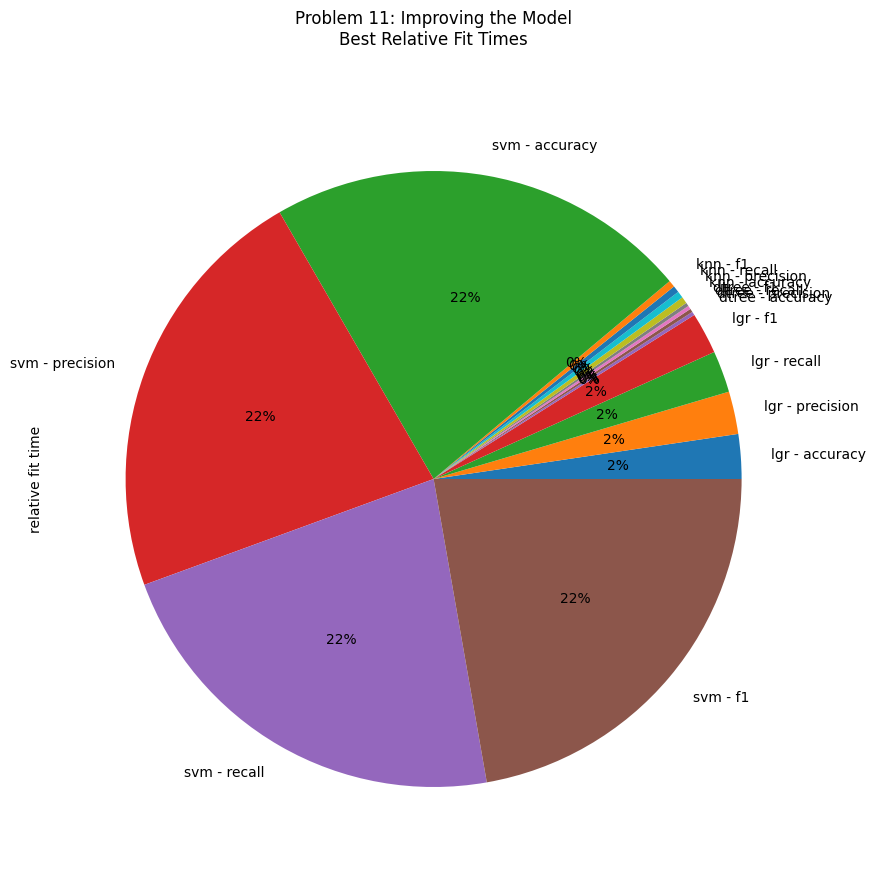

In [43]:
# Relative fit times between classifier model + scoring algorithm
fit = improved_results_df["average fit time"]
improved_results_df["relative fit time"] = fit / fit.sum()
improved_results_df["relative fit time"].plot(kind="pie", autopct='%1.0f%%', figsize=(10,10), title="Problem 11: Improving the Model\nBest Relative Fit Times\n\n");

# Save figure for use in write-up, as needed
plt.savefig(f'images/pa3-results-improved-classifiers-best-relative-fit.png')

In [49]:
improved_results_df["scoring error"] = np.abs( improved_results_df["train score"] - improved_results_df["test score"] )

# view results sorted by Scoring Error, and Relative Fit Time
improved_results_df.sort_values(by=["scoring error", "relative fit time"], inplace=True)

# Save the results to CSV for offline review
improved_results_df.to_csv("results/improving-classifier-performance.csv", index=False)

improved_results_df

,classifier,scoring,train score,test score,cv time,average fit time,best params,relative fit time,scoring error
dtree - precision,Decision Tree,precision,0.8811,0.8801,5.2973,1.2918,"{'clf__max_depth': 2, 'clf__min_impurity_decre...",0.001847,0.0010
dtree - accuracy,Decision Tree,accuracy,0.8811,0.8801,5.2435,1.3009,"{'clf__max_depth': 2, 'clf__min_impurity_decre...",0.001860,0.0010
dtree - recall,Decision Tree,recall,0.8811,0.8801,5.3755,1.3055,"{'clf__max_depth': 2, 'clf__min_impurity_decre...",0.001866,0.0010
dtree - f1,Decision Tree,f1,0.8811,0.8801,5.4549,1.3272,"{'clf__max_depth': 2, 'clf__min_impurity_decre...",0.001897,0.0010
lgr - f1,Logistic Regression,f1,0.8987,0.8967,46.9970,15.2122,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}",0.021745,0.0020
lgr - recall,Logistic Regression,recall,0.8987,0.8967,47.2578,15.3114,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}",0.021887,0.0020
lgr - precision,Logistic Regression,precision,0.8987,0.8967,48.2500,15.6416,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}",0.022359,0.0020
lgr - accuracy,Logistic Regression,accuracy,0.8987,0.8967,50.5314,16.3720,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}",0.023403,0.0020
svm - recall,Support Vector Machines,recall,0.9246,0.8984,509.9336,155.1714,"{'clf__gamma': 0.1, 'clf__kernel': 'rbf'}",0.221809,0.0262
svm - accuracy,Support Vector Machines,accuracy,0.9246,0.8984,510.9031,155.5324,"{'clf__gamma': 0.1, 'clf__kernel': 'rbf'}",0.222325,0.0262


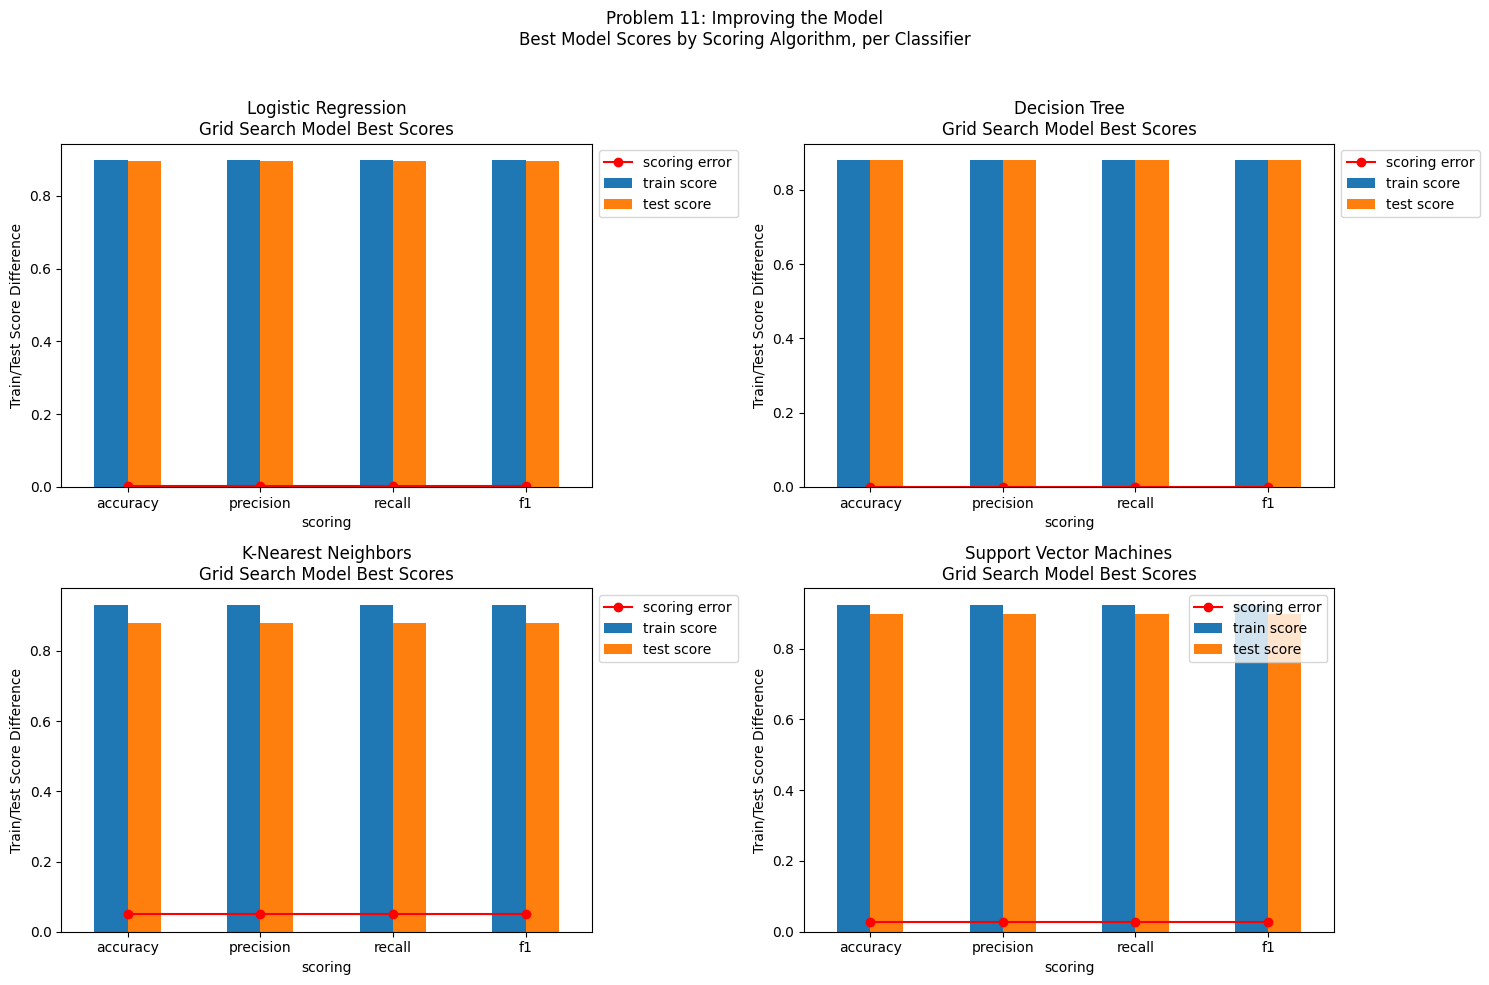

In [45]:
# Classifier model scoring by algorithm
clfs = improved_results_df["classifier"].unique()

improved_results_df["scoring error"] = np.abs( improved_results_df["train score"] - improved_results_df["test score"] )

fig, ax = plt.subplots(2,2,figsize=(15,10))
axe = ax.ravel()
ind = 0
for clf in clfs:
    improved_results_df.query("classifier == @clf").plot(
            x='scoring', 
            y=["train score", "test score"],
            #y = 'scoring error',
            kind='bar',  
            rot=15,
            title=f'{clf}\nGrid Search Model Best Scores',
            ylabel='Train/Test Score Difference',
            xlabel='Grid Search Scoring Algorithms',
            ax=axe[ind]
        )
    improved_results_df.query("classifier == @clf").plot(
            x='scoring', 
            y = 'scoring error',
            kind='line',  
            ax=axe[ind],
            linestyle='-', 
            marker='o',
            color='red'
        )
    axe[ind].legend( bbox_to_anchor =(1 ,1))
    ind += 1

plt.suptitle('Problem 11: Improving the Model\nBest Model Scores by Scoring Algorithm, per Classifier\n\n')
plt.legend()
fig.tight_layout()

# Save figure for use in write-up, as needed
plt.savefig(f'images/pa3-results-best-performance-metric-by-classifier.png')

plt.show()

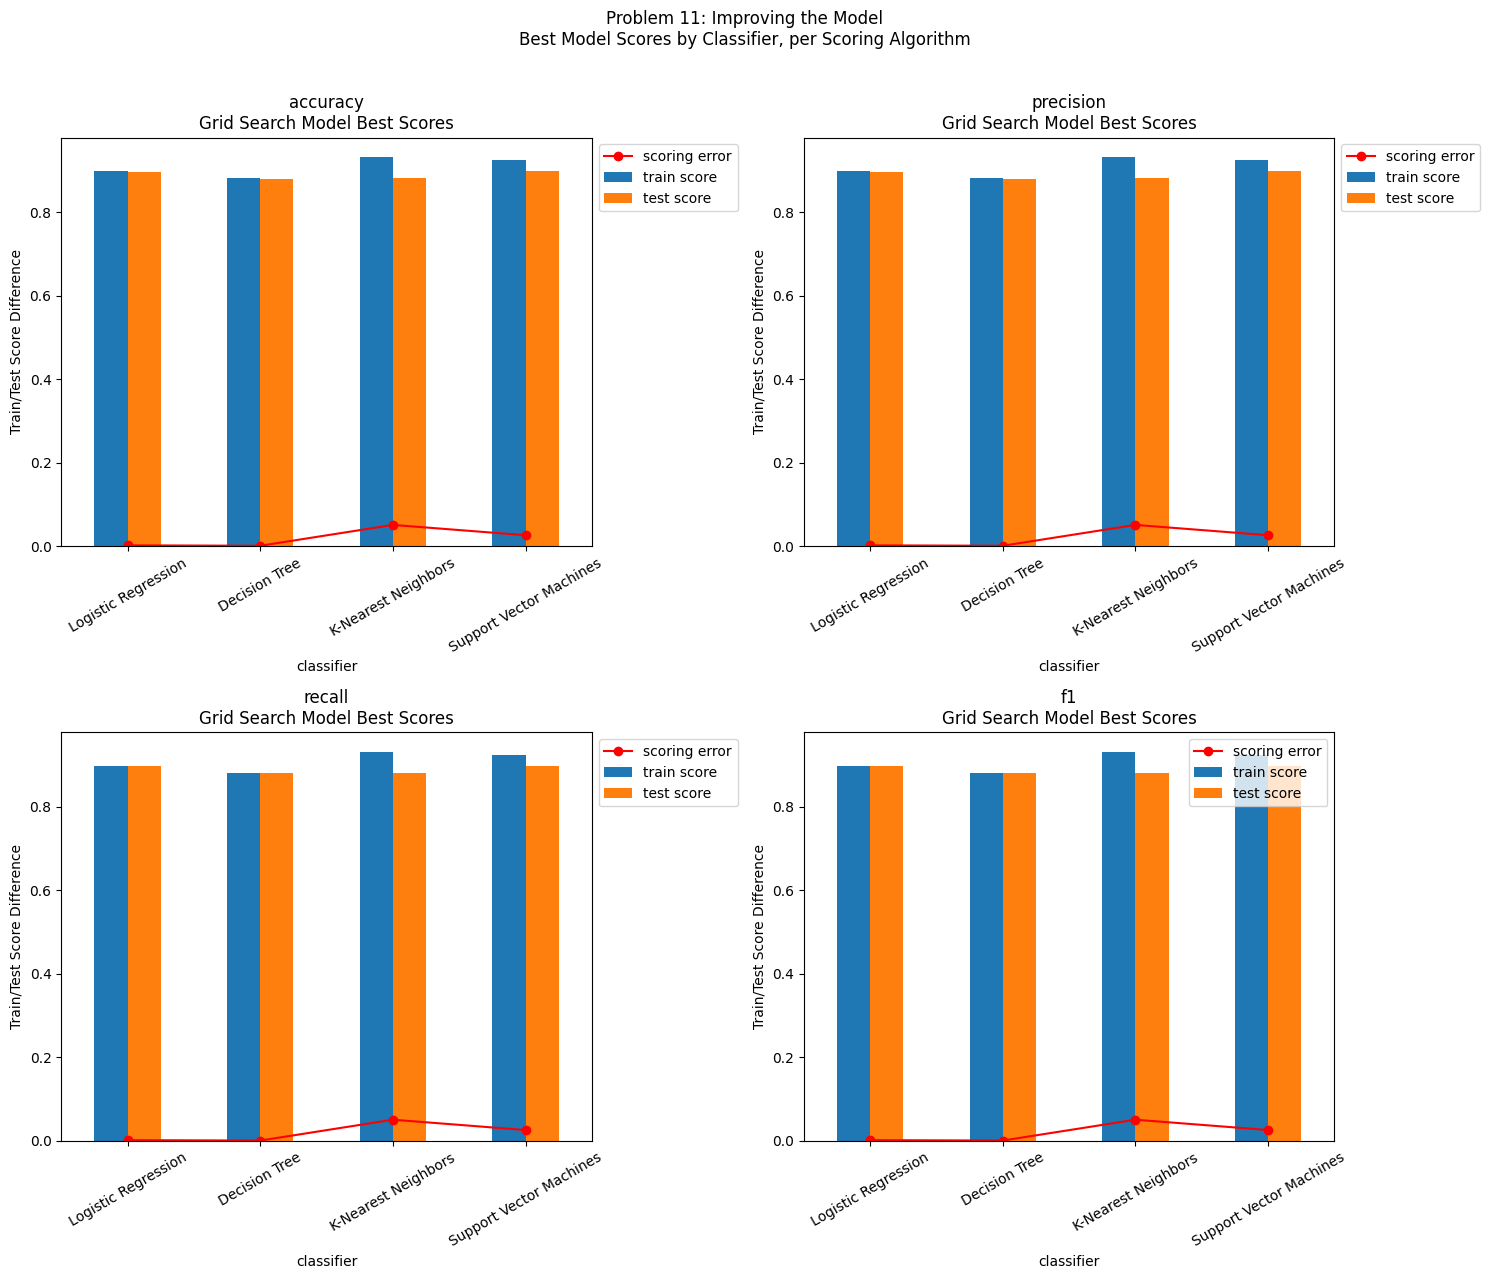

In [46]:
# Classifier model scoring by algorithm
scorers = improved_results_df["scoring"].unique()


fig, ax = plt.subplots(2,2,figsize=(15,13))
axe = ax.ravel()
ind = 0
for scorer in scorers:
    scoring = improved_results_df.query("scoring == @scorer").copy()
    scoring.plot(
            x='classifier', 
            y=["train score", "test score"],
            kind='bar',  
            title=f'{scorer}\nGrid Search Model Best Scores',
            ylabel='Train/Test Score Difference',
            xlabel='Grid Search Classifier Models',
            ax=axe[ind]
        )
    scoring.plot(
            x='classifier', 
            y = 'scoring error',
            kind='line',  
            ax=axe[ind],
            linestyle='-', 
            marker='o',
            color='red'
        )
    axe[ind].legend( bbox_to_anchor =(1 ,1))
    axe[ind].set_xticklabels(scoring["classifier"], rotation=30)
    ind += 1

plt.suptitle('Problem 11: Improving the Model\nBest Model Scores by Classifier, per Scoring Algorithm\n\n')
plt.legend()
fig.tight_layout()

# Save figure for use in write-up, as needed
plt.savefig(f'images/pa3-results-best-scores-by-classifier.png')

plt.show()

In [47]:
scorers

array(['accuracy', 'precision', 'recall', 'f1'], dtype=object)

##### Questions